# Gastric task: Group analysis

### Code to analyse the behvaioural data from multiple participants who completed the _Gastric Sound Discrimination Task_, as distributed in the Em-Body toolkit

### Set environment

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np
from IPython.display import display, HTML


from sklearn.metrics import roc_curve, auc

from pymer4.models import Lmer

from scipy import stats
from scipy.stats import norm, mannwhitneyu, ttest_rel
import statsmodels.stats.multitest as smm

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from p_toolkit.core import *

p_vals = []

ModuleNotFoundError: No module named 'pandas'

### Get chance distribution

  Percentage  Two-Tailed P-Value
0        75%              0.2059
1        76%              0.2059
2        77%              0.2059
3        78%              0.2059
4        79%              0.2059
5        80%              0.0578
6        81%              0.0578
7        82%              0.0578
8        83%              0.0578
9        84%              0.0578


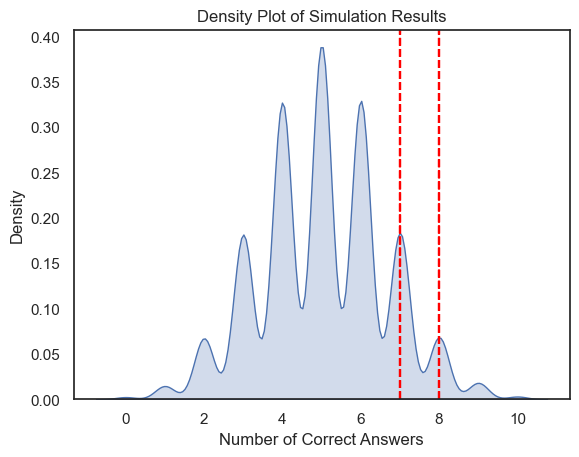

In [ ]:
def simulate_trials(n_simulations=10000, n_trials=10, p_correct=0.5):
    """Simulates random guessing over multiple trials."""
    results = np.random.binomial(n_trials, p_correct, n_simulations)
    return results

def calculate_probabilities(sim_results, percentages, n_trials=10, p_correct=0.5):
    """Calculates the two-tailed probability of achieving a given percentage or more extreme."""
    # The mean and standard deviation for the binomial distribution (normal approximation)
    mean = n_trials * p_correct
    std_dev = np.sqrt(n_trials * p_correct * (1 - p_correct))
    
    # Convert percentages to the number of correct answers
    thresholds = [int(p * n_trials) for p in percentages]
    
    probabilities = []
    for threshold in thresholds:
        # Calculate z-scores for the lower and upper tails
        z_lower = (threshold - mean) / std_dev
        z_upper = (n_trials - threshold - mean) / std_dev
        
        # Find the one-tailed p-value for each tail using the normal distribution
        p_lower = norm.cdf(z_lower)
        p_upper = norm.cdf(z_upper)
        
        # Two-tailed p-value: sum the two one-tailed p-values, considering symmetry
        p_value = 2 * min(p_lower, p_upper)
        
        # Append p-value rounded to 4 decimal places
        probabilities.append(round(p_value, 4))
    
    # Prepare the result as a DataFrame
    df = pd.DataFrame({
        'Percentage': [f"{int(p * 100)}%" for p in percentages],
        'Two-Tailed P-Value': probabilities
    })
    
    return df, thresholds

# Run the simulation
sim_results = simulate_trials()

# Example: Get probabilities for several percentages
percentages_to_check = [i / 100 for i in range(75, 85)]
#percentages_to_check = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # 10%, 20%, ..., 90%
df_probabilities, thresholds = calculate_probabilities(sim_results, percentages_to_check)

# Display the results as a DataFrame
print(df_probabilities)

# Plot density plot of simulation results
sns.kdeplot(sim_results, fill=True)
plt.xlabel("Number of Correct Answers")
plt.ylabel("Density")
plt.title("Density Plot of Simulation Results")

# Add vertical red lines for each percentage threshold
for threshold in thresholds:
    plt.axvline(threshold, color='red', linestyle='--')

plt.show()

## 80% ACCURACY IS THE THRESHOLD FOR CHANCE ##

### Get demographics

In [ ]:
folder_path = ''  # Update with your folder path
recap_file = 'Demographics.txt'
file_path = os.path.join(folder_path, recap_file)
redcap_df = pd.read_csv(file_path, sep='\t') 
#print(redcap_df)
print(redcap_df['Participant_ID'].dtype)

# List of excluded IDs
excluded = [5, 19, 42, 46, 78, 124]
''' 
    Exclusions: 
    - 005: Unsure if stethoscope was well attached 
    - 019: No Huel
    - 042: Did not complete gastric task (stethoscope ran out of battery before session)
    - 046: No Huel
    - 078: First 5 trials phone was ringing and loud construction noise throughout
    - 124: No Huel
'''

# Filter out rows with excluded ParticipantIDs
redcap_df_exclusions = redcap_df[~redcap_df['Participant_ID'].isin(excluded)]

print(redcap_df_exclusions)

summary = {}

# Age: report mean, std, min, max, median
summary['demo_age'] = {
    'Mean': redcap_df_exclusions['demo_age'].mean(),
    'SD': redcap_df_exclusions['demo_age'].std(),
    'Min': redcap_df_exclusions['demo_age'].min(),
    'Max': redcap_df_exclusions['demo_age'].max(),
    'Median': redcap_df_exclusions['demo_age'].median(),
    'N': redcap_df_exclusions['demo_age'].count()
}

# Gender: report counts and percentages
gender_counts = redcap_df_exclusions['demo_gender'].value_counts(dropna=False)
gender_percent = redcap_df_exclusions['demo_gender'].value_counts(normalize=True, dropna=False) * 100
summary['demo_gender'] = pd.DataFrame({
    'Count': gender_counts,
    'Percent': gender_percent.round(1)
})

# Gender Other: report how many non-null entries
summary['demo_gender_other'] = {
    'N (specified)': redcap_df_exclusions['demo_gender_other'].notnull().sum()
}

# Sex: counts and percentages
sex_counts = redcap_df_exclusions['demo_sex'].value_counts(dropna=False)
sex_percent = redcap_df_exclusions['demo_sex'].value_counts(normalize=True, dropna=False) * 100
summary['demo_sex'] = pd.DataFrame({
    'Count': sex_counts,
    'Percent': sex_percent.round(1)
})

# Print everything
for key, value in summary.items():
    print(f"\n=== {key} ===")
    if isinstance(value, pd.DataFrame):
        print(value)
    elif isinstance(value, dict):  # e.g. demo_age or demo_gender_other
        print(pd.Series(value))
    else:
        print(value)


int64
    Unnamed: 0  Participant_ID redcap_event_name  demo_age  demo_gender  \
0            0               4  researcher_arm_1        19            2   
2            2               6  researcher_arm_1        34            1   
3            3               7  researcher_arm_1        19            2   
4            4               8  researcher_arm_1        22            1   
5            5              11  researcher_arm_1        27            2   
7            7              24  researcher_arm_1        21            2   
8            8              28  researcher_arm_1        35            1   
9            9              30  researcher_arm_1        29            2   
10          10              36  researcher_arm_1        20            2   
11          11              37  researcher_arm_1        21            2   
12          12              40  researcher_arm_1        20            2   
14          14              43  researcher_arm_1        18            2   
15          15     

### Load and concatenate the 'gastric_stethoscope.tsv' files into a dataframe

In [ ]:
# Specify the folder containing your .tsv files
folder_path = ''  # Update with your folder path
save_dir = '' # Update with your desired save directory

# Load all TSV files from the specified directory
data = []
file_names = []  # To store the participant IDs based on filenames
for filename in os.listdir(folder_path):
    if filename.endswith("gastric_stethoscope.tsv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t', header=1)  # Skip the first row (header)

        # Filter rows where 'Trial' is not numeric
        df = df[df['Trial'].str.isnumeric()]  # Keep only rows where 'Trial' is numeric
        df['Trial'] = df['Trial'].astype(int)  # Convert 'Trial' to integers
        df['Participant_Sound_Loc'] = df['Participant_Sound_Loc'].astype(int)
        df['Response_code'] = df['Response_code'].astype(int)
        df['Confidence'] = df['Confidence'].astype(int)
        
        # Exclude rows above the first instance where Trial = 0
        first_trial_zero_idx = df[df['Trial'] == 0].index.min()
        if not pd.isna(first_trial_zero_idx):
            df = df.loc[first_trial_zero_idx:]

        data.append(df)

        # Extract the participant ID from the filename (assuming the format "sub-XXX_gastric_stethascope.tsv")
        participant_id = filename.split('_')[0]  # Get the part before the first underscore (sub-XXX)
        file_names.append(participant_id)

# Concatenate all data into a single DataFrame
df = pd.concat(data, ignore_index=True)


# Add a new column for participant ID (from the filename)
# Remove 'sub-' prefix from filenames if present
cleaned_file_names = [name.replace('sub-', '') for name in file_names]

# Add the cleaned participant IDs to the DataFrame
df['Participant'] = np.repeat(cleaned_file_names, [len(data[i]) for i in range(len(data))])
display(HTML(df.head().to_html()))

## BEHAVIOUR: ACCURACY + CONFIDENCE PER CONDITION
Group per trial_sets = [(0, 9), (10, 19), (20, 29)] into fasted - sparkling_water - protein_shake conditions

In [ ]:
# Accuracy Calculation
accuracy_results = []

# Split trials into sets of 0-9, 10-19, 20-29
trial_sets = [(0, 9), (10, 19), (20, 29)]

for start, end in trial_sets:
    subset = df[(df['Trial'] >= start) & (df['Trial'] <= end)]
    
    # Calculate accuracy for each participant
    for participant in subset['Participant'].unique():
        participant_data = subset[subset['Participant'] == participant]
        correct = np.sum(participant_data['Participant_Sound_Loc'] == participant_data['Response_code'])
        total = len(participant_data)
        accuracy = (correct / total) * 100 if total > 0 else 0  # Avoid division by zero
        trial_range = f'{start}-{end}'
        confidence = participant_data['Confidence'].mean()
        
        # Assign condition based on trial range
        if trial_range == '0-9':
            condition = 'fasted'
        elif trial_range == '10-19':
            condition = 'sparkling_water'
        elif trial_range == '20-29':
            condition = 'protein_shake'
        else:
            condition = 'unknown'
            
        accuracy_results.append({
            'Participant': participant,
            'Trial_Range': trial_range,
            'Condition': condition,
            'Accuracy_percent': accuracy,
            'Confidence': confidence
        })

# Convert accuracy results to DataFrame
accuracy_df = pd.DataFrame(accuracy_results)

# Calculate 95% confidence intervals for Accuracy_percent and Confidence
def calculate_ci(group):
    # Calculate mean, standard deviation, and count for the group
    mean_accuracy = group['Accuracy_percent'].mean()
    std_accuracy = group['Accuracy_percent'].std()
    count_accuracy = len(group)
    
    mean_confidence = group['Confidence'].mean()
    std_confidence = group['Confidence'].std()
    count_confidence = len(group)
    
    # Calculate 95% CI for Accuracy_percent
    accuracy_ci_lower = mean_accuracy - 1.96 * (std_accuracy / np.sqrt(count_accuracy))
    accuracy_ci_upper = mean_accuracy + 1.96 * (std_accuracy / np.sqrt(count_accuracy))
    
    # Calculate 95% CI for Confidence
    confidence_ci_lower = mean_confidence - 1.96 * (std_confidence / np.sqrt(count_confidence))
    confidence_ci_upper = mean_confidence + 1.96 * (std_confidence / np.sqrt(count_confidence))
    
    return pd.Series({
        'Accuracy_mean': mean_accuracy,
        'Accuracy_std': std_accuracy,
        'Accuracy_95CI_lower': accuracy_ci_lower,
        'Accuracy_95CI_upper': accuracy_ci_upper,
        'Confidence_mean': mean_confidence,
        'Confidence_std': std_confidence,
        'Confidence_95CI_lower': confidence_ci_lower,
        'Confidence_95CI_upper': confidence_ci_upper
    })

# Group by 'Condition' and apply the CI calculation
accuracy_with_ci = accuracy_df.groupby('Condition').apply(calculate_ci)

# Display the results
from IPython.core.display import display, HTML
display(HTML(accuracy_df.to_html()))  # Show the accuracy dataframe as HTML
accuracy_df.describe()  # Descriptive statistics of the accuracy data
accuracy_with_ci  # Results with 95% Confidence Intervals


C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\1970851689.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_with_ci = accuracy_df.groupby('Condition').apply(calculate_ci)
C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\1970851689.py:74: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Accuracy_mean  Accuracy_std  Accuracy_95CI_lower  \
Condition                                                           
fasted               55.777778     20.392611            49.819474   
protein_shake        59.777778     22.206560            53.289475   
sparkling_water      58.888889     22.383255            52.348960   

                 Accuracy_95CI_upper  Confidence_mean  Confidence_std  \
Condition                                                               
fasted                     61.736082        36.388889       19.984531   
protein_shake              66.266081        38.746667       20.856562   
sparkling_water            65.428818        40.086667       22.497592   

                 Confidence_95CI_lower  Confidence_95CI_upper  
Condition                                                      
fasted                       30.549818              42.227960  
protein_shake                32.652806              44.840528  
sparkling_water              33.513330              46.660003

In [ ]:
# Set the threshold for accuracy
accuracy_threshold = 80

# Calculate the number and percentage of participants who have accuracy > 80% for each condition
for condition in accuracy_df['Condition'].unique():
    # Filter the data for participants with accuracy > 80% in the current condition
    filtered_participants = accuracy_df[(accuracy_df['Condition'] == condition) & (accuracy_df['Accuracy_percent'] >= accuracy_threshold)]
    
    # Calculate the number and percentage of participants
    num_participants = len(filtered_participants)
    total_participants = len(accuracy_df[accuracy_df['Condition'] == condition])
    percentage_participants = (num_participants / total_participants) * 100
    
    # Print the results for each condition
    print(f"Condition: {condition}")
    print(f"Number of participants with accuracy > {accuracy_threshold}%: {num_participants}")
    print(f"Percentage: {percentage_participants:.2f}%\n")


Condition: fasted
Number of participants with accuracy > 80%: 8
Percentage: 17.78%

Condition: sparkling_water
Number of participants with accuracy > 80%: 12
Percentage: 26.67%

Condition: protein_shake
Number of participants with accuracy > 80%: 11
Percentage: 24.44%



## BEHAVIOUR: ACCURACY - mixed linear model
A mixed linear model to examine the effect of the experimental conditions (fasted, sparkling_water, and protein_shake) on accuracy percentage while accounting for random intercepts across participants. 

Modelled using Restricted Maximum Likelihood (REML) method.

In [ ]:
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], categories=['fasted', 'sparkling_water', 'protein_shake'], ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

import numpy as np
from pymer4.models import Lmer
#from pymer4.stats import contrast
from scipy.stats import norm

# Fit the model
md = Lmer('Accuracy_percent ~ Condition + (1|Participant)', data=accuracy_df)
md.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})
print(md.summary())

summary = md.summary()
results = []

# Iterate over the rows in the summary
for _, row in summary.iterrows():
    # Use the index for the predictor (this is the row label, not a column)
    results.append(('Acc_cond', row.name, row['P-val']))  # 'name' is the index, which is the predictor

print(results)

Linear mixed model fit by REML [’lmerMod’]
Formula: Accuracy_percent~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -596.350 	 AIC: 1202.700

Random effects:

                    Name      Var     Std
Participant  (Intercept)  100.269  10.013
Residual                  369.731  19.228

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Accuracy_percent~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -596.350 	 AIC: 1202.700

Random effects:

                    Name      Var     Std
Participant  (Intercept)  100.269  10.013
Residual                  369.731  19.228

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    55.778  49.444   62.112  3.232

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


## BEHAVIOUR: ACCURACY - Plot

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


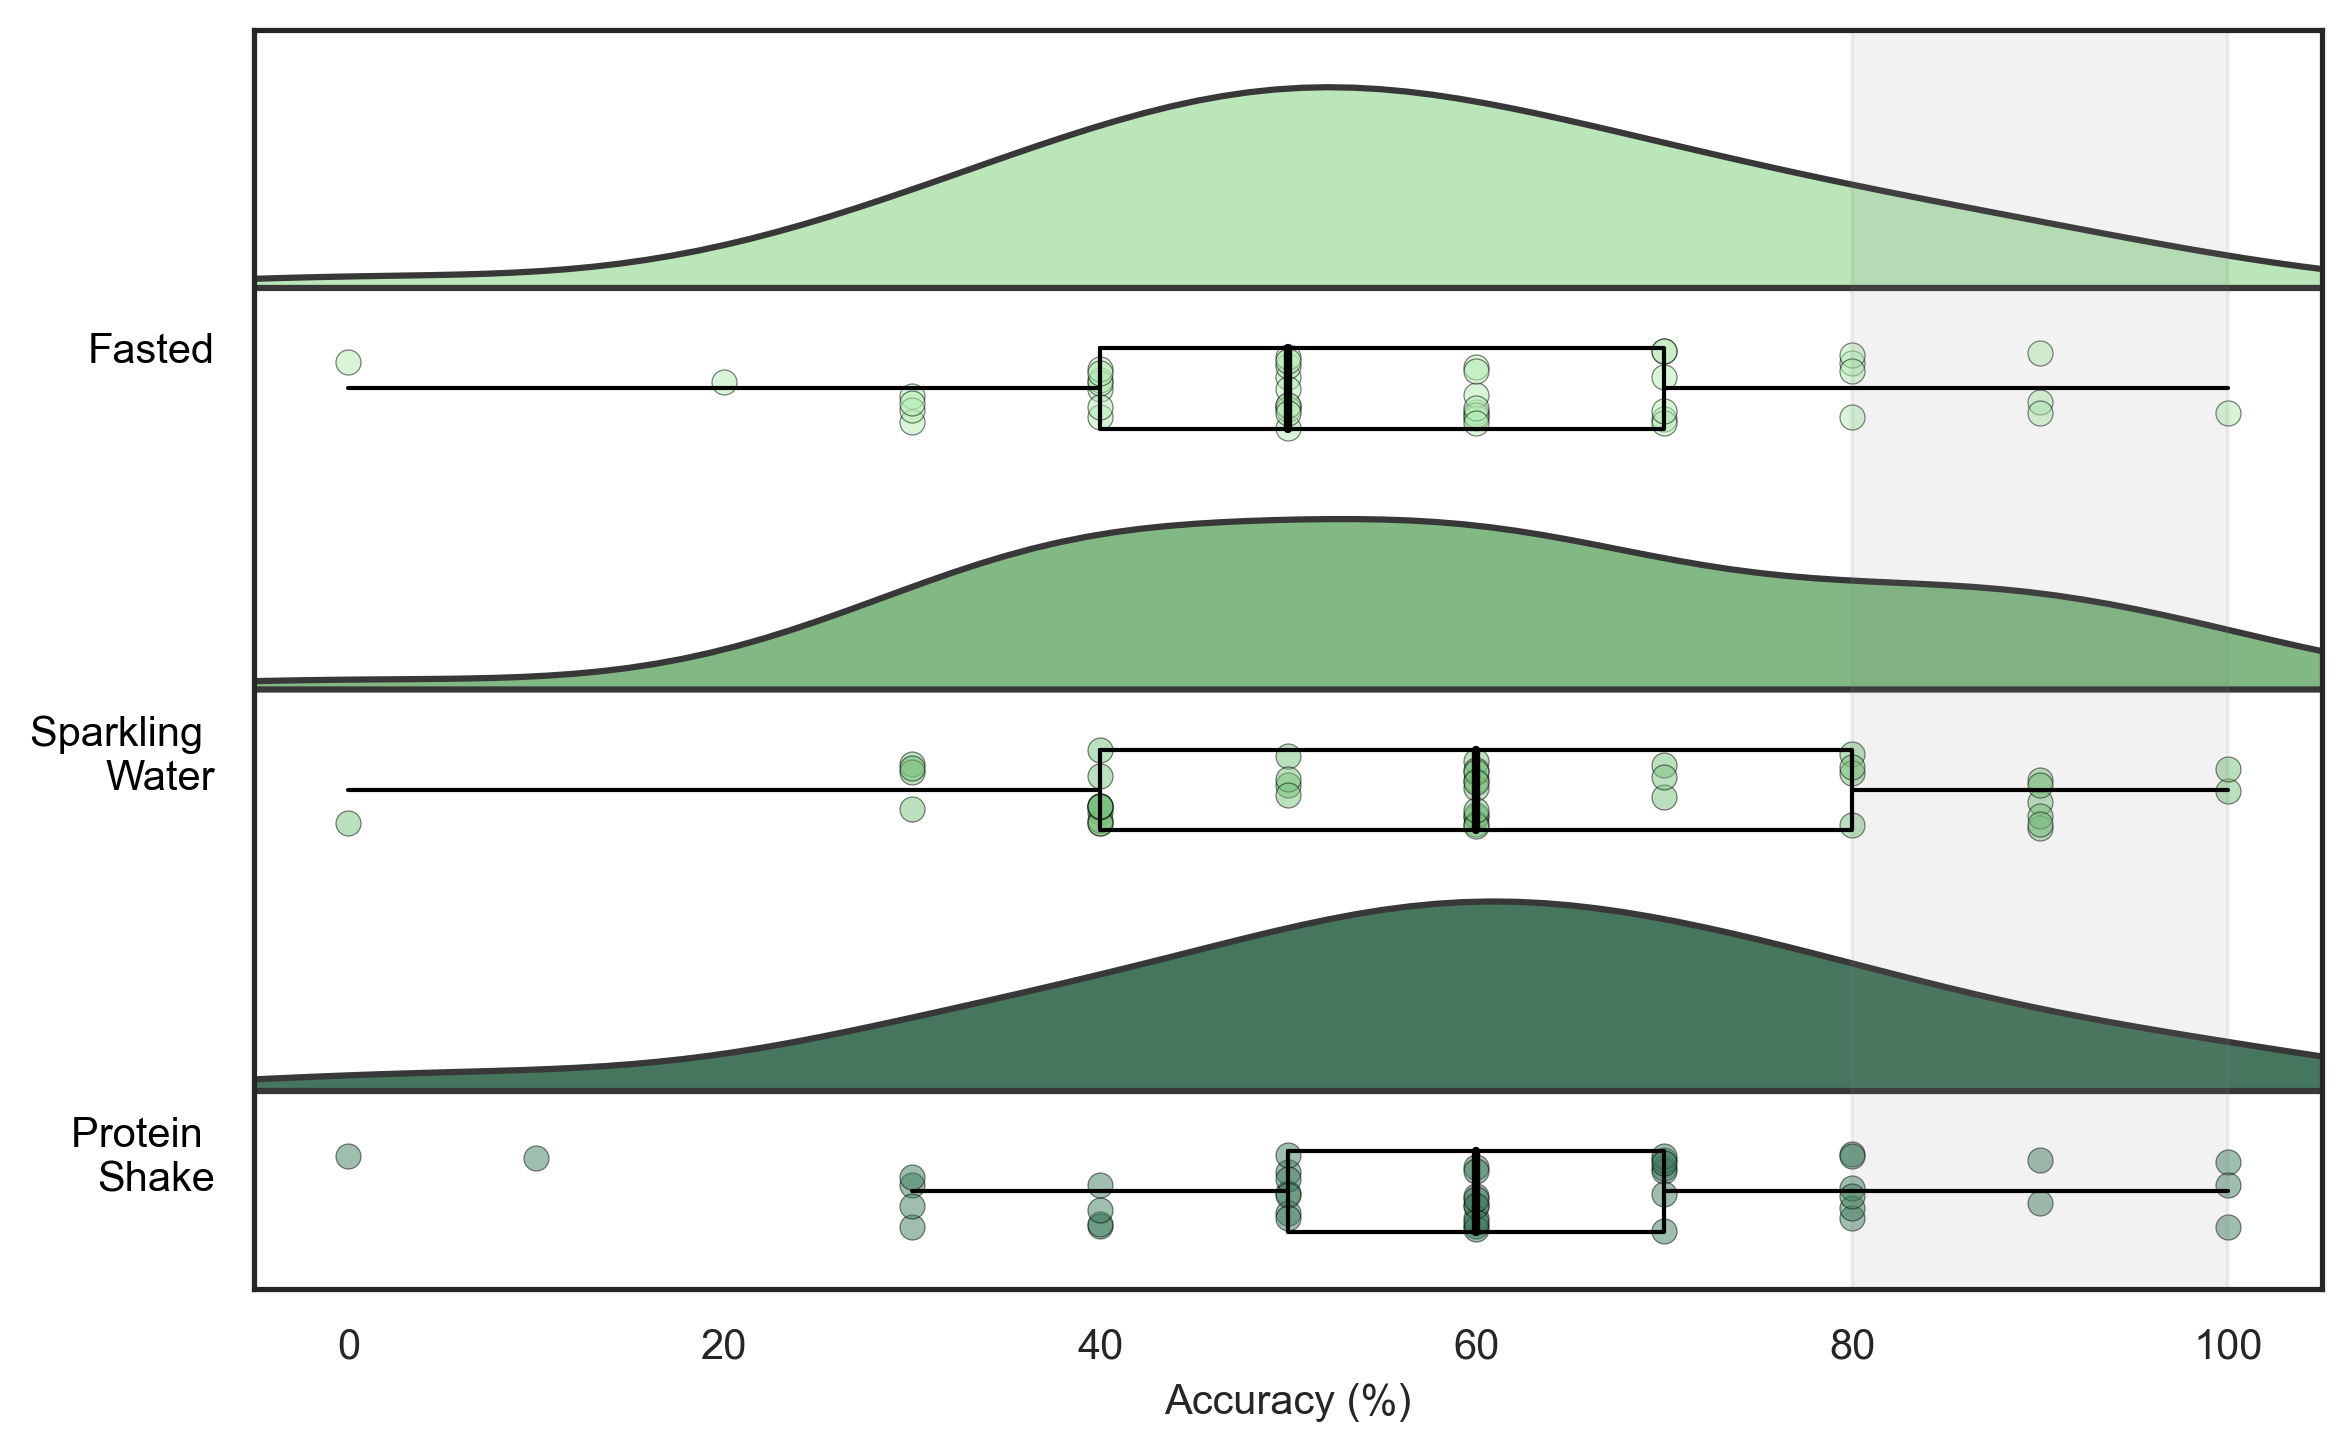

In [ ]:
# Ensure 'Condition' and 'Participant' are categorical
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], 
                                           categories=['fasted', 'sparkling_water', 'protein_shake'],
                                           ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

# Define a neutral green color palette
condition_palette = {
    'fasted':  (0.702, 0.929, 0.702) ,        # Dark green (scientific & muted)
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake':   (0.243, 0.494, 0.369)# Soft, light green (neutral)
}

# Create the figure
fig, ax = plt.subplots(figsize=(8, 5), dpi = 300)

# Half violin plot (raincloud plot)
pt.half_violinplot(
    x="Accuracy_percent", y="Condition", scale="area", 
    palette=condition_palette, inner=None, data=accuracy_df, width=1,
    ax=ax
)

# Add individual data points as scatter plot
for i, condition in enumerate(accuracy_df['Condition'].unique()):
    data = accuracy_df[accuracy_df["Condition"] == condition]
    y = i + np.random.uniform(high=0.2, size=len(data))  # Add some jitter
    x = data["Accuracy_percent"]
    ax.scatter(x, y, color=condition_palette[condition], alpha=0.5, edgecolor='black', linewidth=0.3)

# Positions for boxplot
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT]

# Boxplot for each condition (add median line and adjust appearance)
medianprops = dict(color='black', linewidth=2)
boxprops = dict(color='black', linewidth=1)

# Calculate the boxplot data
boxplot_data = [
    accuracy_df[accuracy_df['Condition'] == condition]['Accuracy_percent'].values
    for condition in accuracy_df['Condition'].unique()
]

ax.boxplot(
    boxplot_data, 
    vert=False, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False,  # Hide the outliers
    showcaps=False,    # Hide the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.2 
)

# Add labels and title
ax.set_xlabel("Accuracy (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_yticklabels(['Fasted', 'Sparkling \nWater', 'Protein \nShake'], fontsize=10,  color='black')
# Add a shaded area for accuracy >= 80%
ax.axvspan(80, 100, color='gray', alpha=0.1)  # Light gray shading with low opacity
ax.set_xlim(-5,105)

# Change size of tick labels
ax.tick_params(labelsize=10)

# Show the plot
plt.tight_layout()
plt_name = 'Accuracy_by_Condition.png'
plt_save_path = save_dir + '/' + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches='tight')
plt.show()


### BEHAVIOUR: ACCURACY - Change

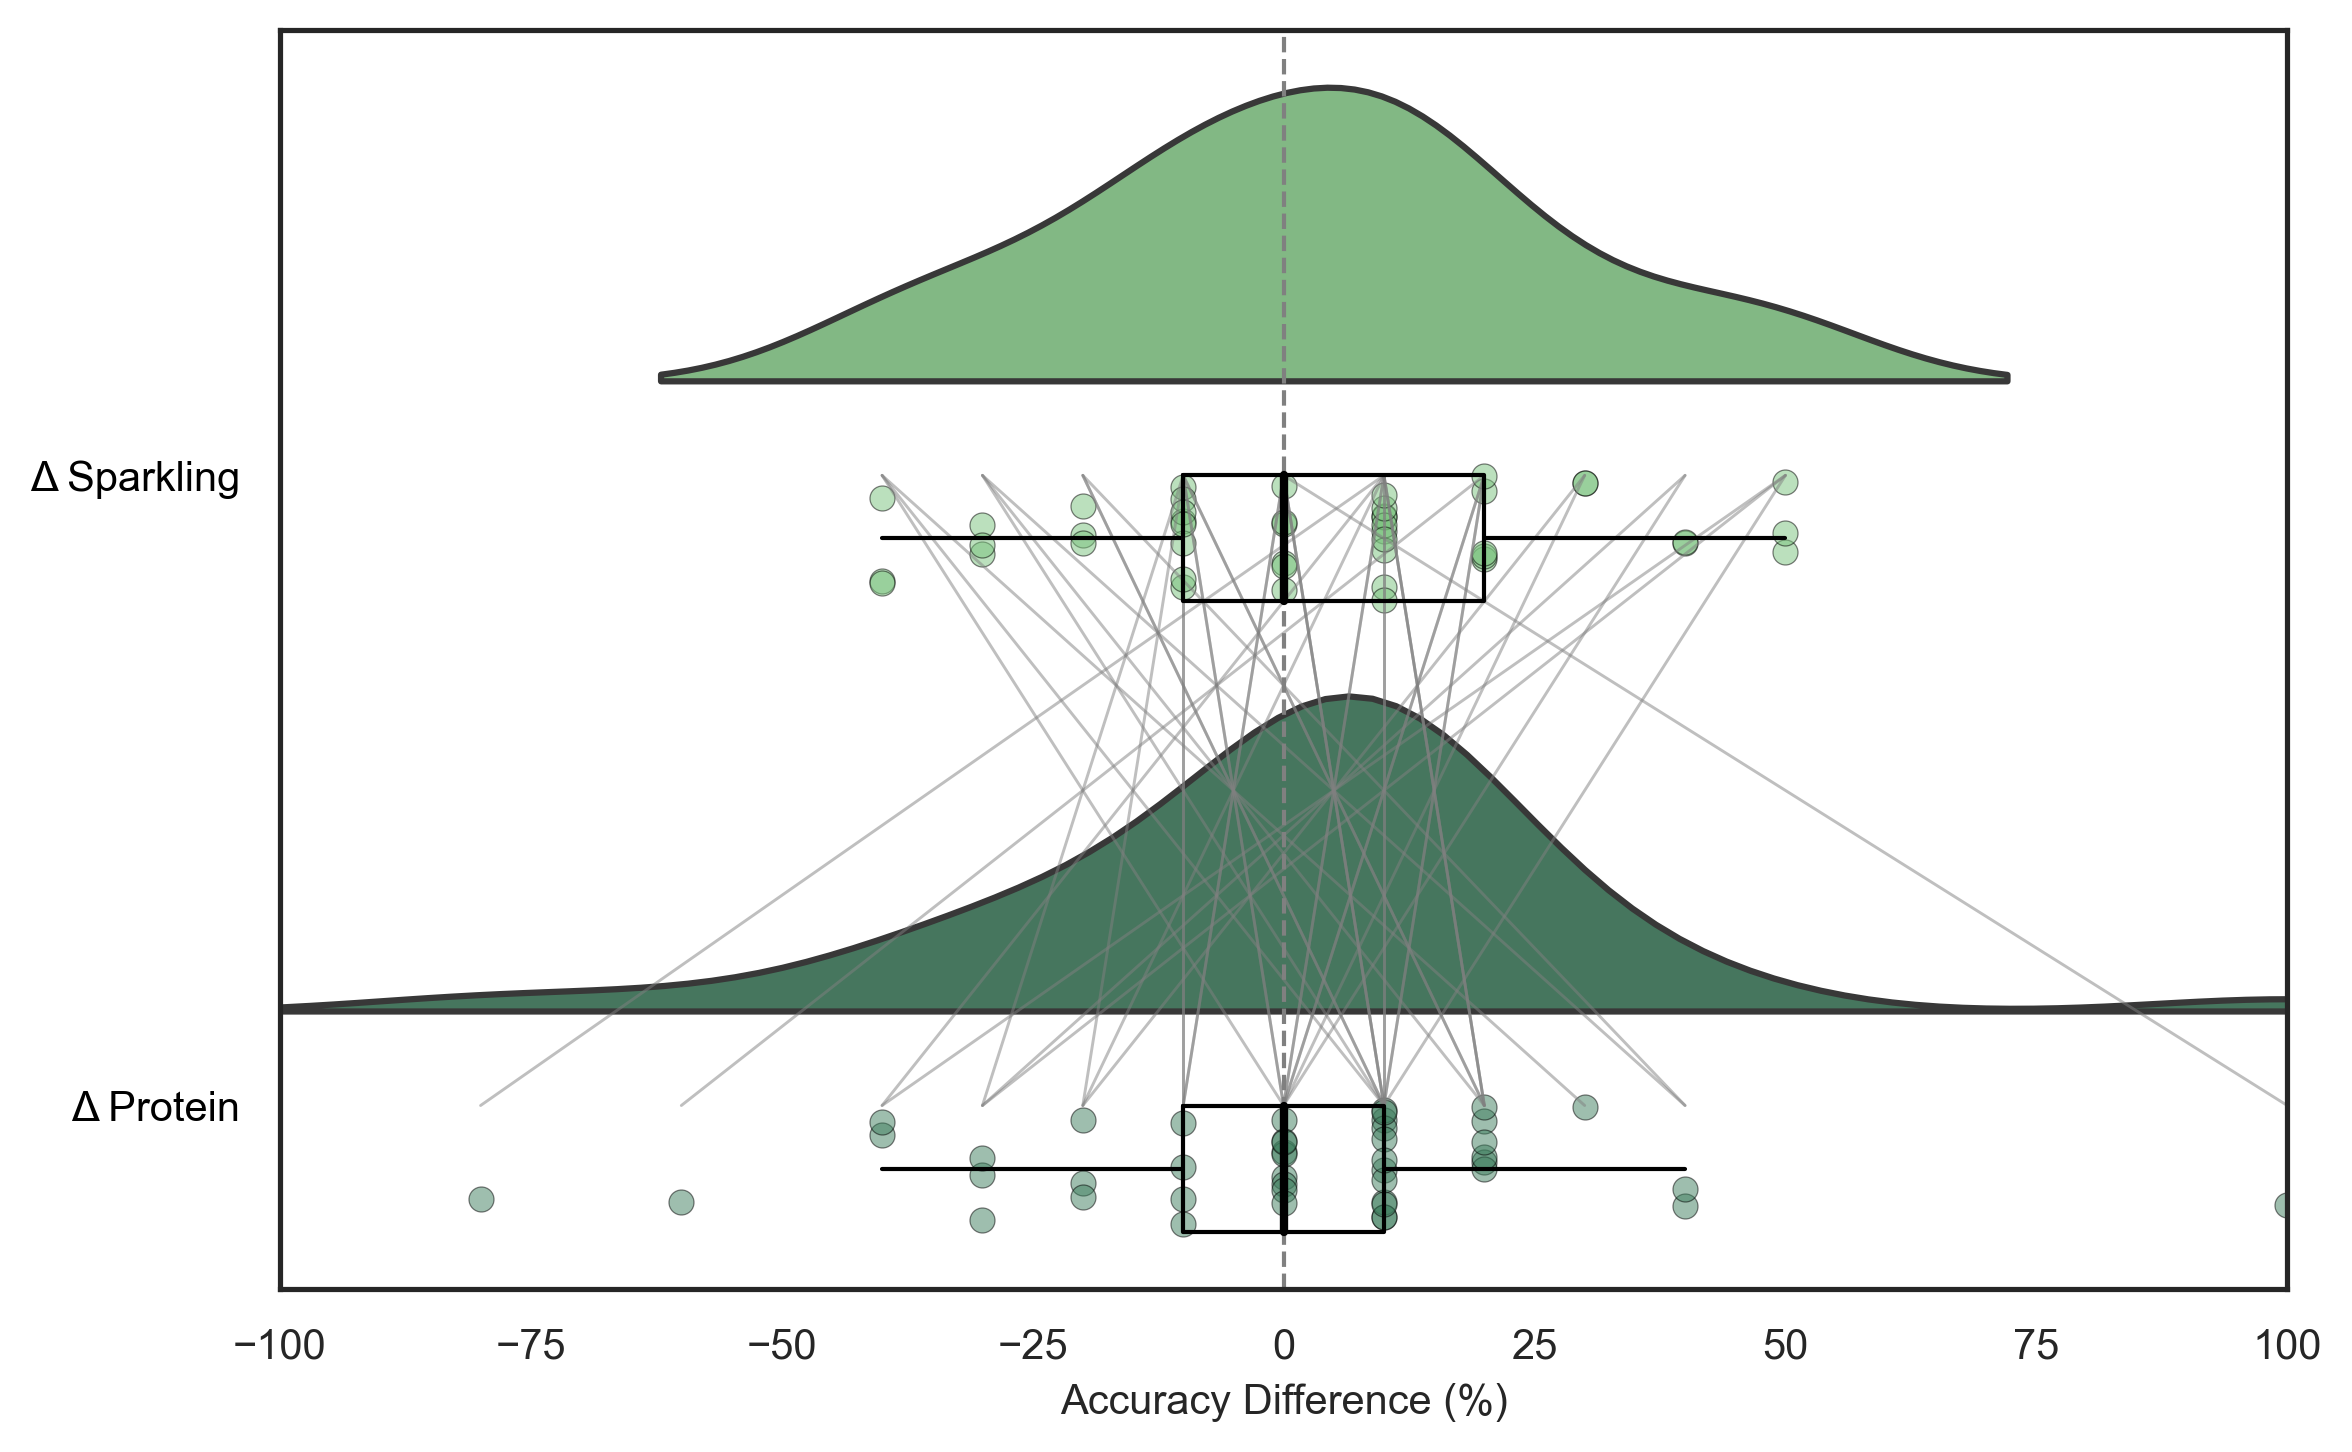

In [ ]:
# Pivot the DataFrame to align participant data for condition comparisons
accuracy_pivot = accuracy_df.pivot(index="Participant", columns="Condition", values="Accuracy_percent")

# Compute differences
accuracy_diff_df = pd.DataFrame({
    "Participant": accuracy_pivot.index,
    "Sparkling - Fasted": accuracy_pivot["sparkling_water"] - accuracy_pivot["fasted"],
    "Protein - Sparkling": accuracy_pivot["protein_shake"] - accuracy_pivot["sparkling_water"]
})

# Reshape DataFrame for plotting
accuracy_diff_melted = accuracy_diff_df.melt(id_vars=["Participant"], 
                                             var_name="Comparison", 
                                             value_name="Accuracy_Difference")

# Define color palette
diff_palette = {
    "Sparkling - Fasted": (0.474, 0.759, 0.486), 
    "Protein - Sparkling": (0.243, 0.494, 0.369)  
}

# Create the figure
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Half violin plot
pt.half_violinplot(
    x="Accuracy_Difference", y="Comparison", scale="area", 
    palette=diff_palette, inner=None, data=accuracy_diff_melted, width=1,
    ax=ax
)

# Scatter plot for individual data points & connecting lines
for participant in accuracy_diff_df["Participant"]:
    # Get participant's data
    participant_data = accuracy_diff_melted[accuracy_diff_melted["Participant"] == participant]
    
    # X (Accuracy Difference) values
    x_values = participant_data["Accuracy_Difference"].values
    # Y positions for "Fasted - Sparkling" (0) and "Sparkling - Protein" (1)
    y_values = [0, 1]

    if len(x_values) == 2:  # Ensure both values exist
        ax.plot(x_values, y_values, color='gray', alpha=0.5, linestyle='-', linewidth=0.7)  # Line between points

    # Scatter points
    for i, comparison in enumerate(participant_data["Comparison"]):
        x = participant_data.loc[participant_data["Comparison"] == comparison, "Accuracy_Difference"].values
        y = i + np.random.uniform(high=0.2, size=len(x))  # Add jitter
        ax.scatter(x, y, color=diff_palette[comparison], alpha=0.5, edgecolor='black', linewidth=0.3)

# Boxplot positions
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT]

# Boxplot data
boxplot_data = [
    accuracy_diff_melted[accuracy_diff_melted['Comparison'] == comparison]['Accuracy_Difference'].values
    for comparison in accuracy_diff_melted["Comparison"].unique()
]

# Boxplot aesthetics
medianprops = dict(color='black', linewidth=2)
boxprops = dict(color='black', linewidth=1)

ax.boxplot(
    boxplot_data, 
    vert=False, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False, 
    showcaps=False,    
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.2 
)

# Labels and formatting
ax.set_xlabel("Accuracy Difference (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_yticklabels(["Δ Sparkling", "Δ Protein"], fontsize=10, color='black')

# Reference line at 0 (no difference)
ax.axvline(0, color='gray', linestyle="--", linewidth=1)

# Adjust plot limits
ax.set_xlim(-100, 100)  # Adjust based on data range

# Change tick label size
ax.tick_params(labelsize=10)

# Show the plot
plt.tight_layout()
plt_name = 'Accuracy_Difference_by_Comparison.png'
plt_save_path = save_dir + '/' + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches='tight')
plt.show()

## BEHAVIOUR: CONFIDENCE

In [ ]:
# Set up categorical variables
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], categories=['fasted', 'sparkling_water', 'protein_shake'], ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

# Define your model using Lmer
md = Lmer('Confidence ~ Condition + (1|Participant)', data=accuracy_df)
md.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})

# Display the model results
print(md.summary())
summary = md.summary()

results = []

# Iterate over the rows in the summary
for _, row in summary.iterrows():
    print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append(('Conf_cond', row.name, row['P-val']))  # 'name' is the index, which is the predictor

print(results)

Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -544.532 	 AIC: 1099.065

Random effects:

                    Name      Var     Std
Participant  (Intercept)  360.556  18.988
Residual                   86.284   9.289

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -544.532 	 AIC: 1099.065

Random effects:

                    Name      Var     Std
Participant  (Intercept)  360.556  18.988
Residual                   86.284   9.289

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    36.389  30.213   42.565  3.151  57.337  11.

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


## BEHAVIOUR: CONFIDENCE - Plot

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


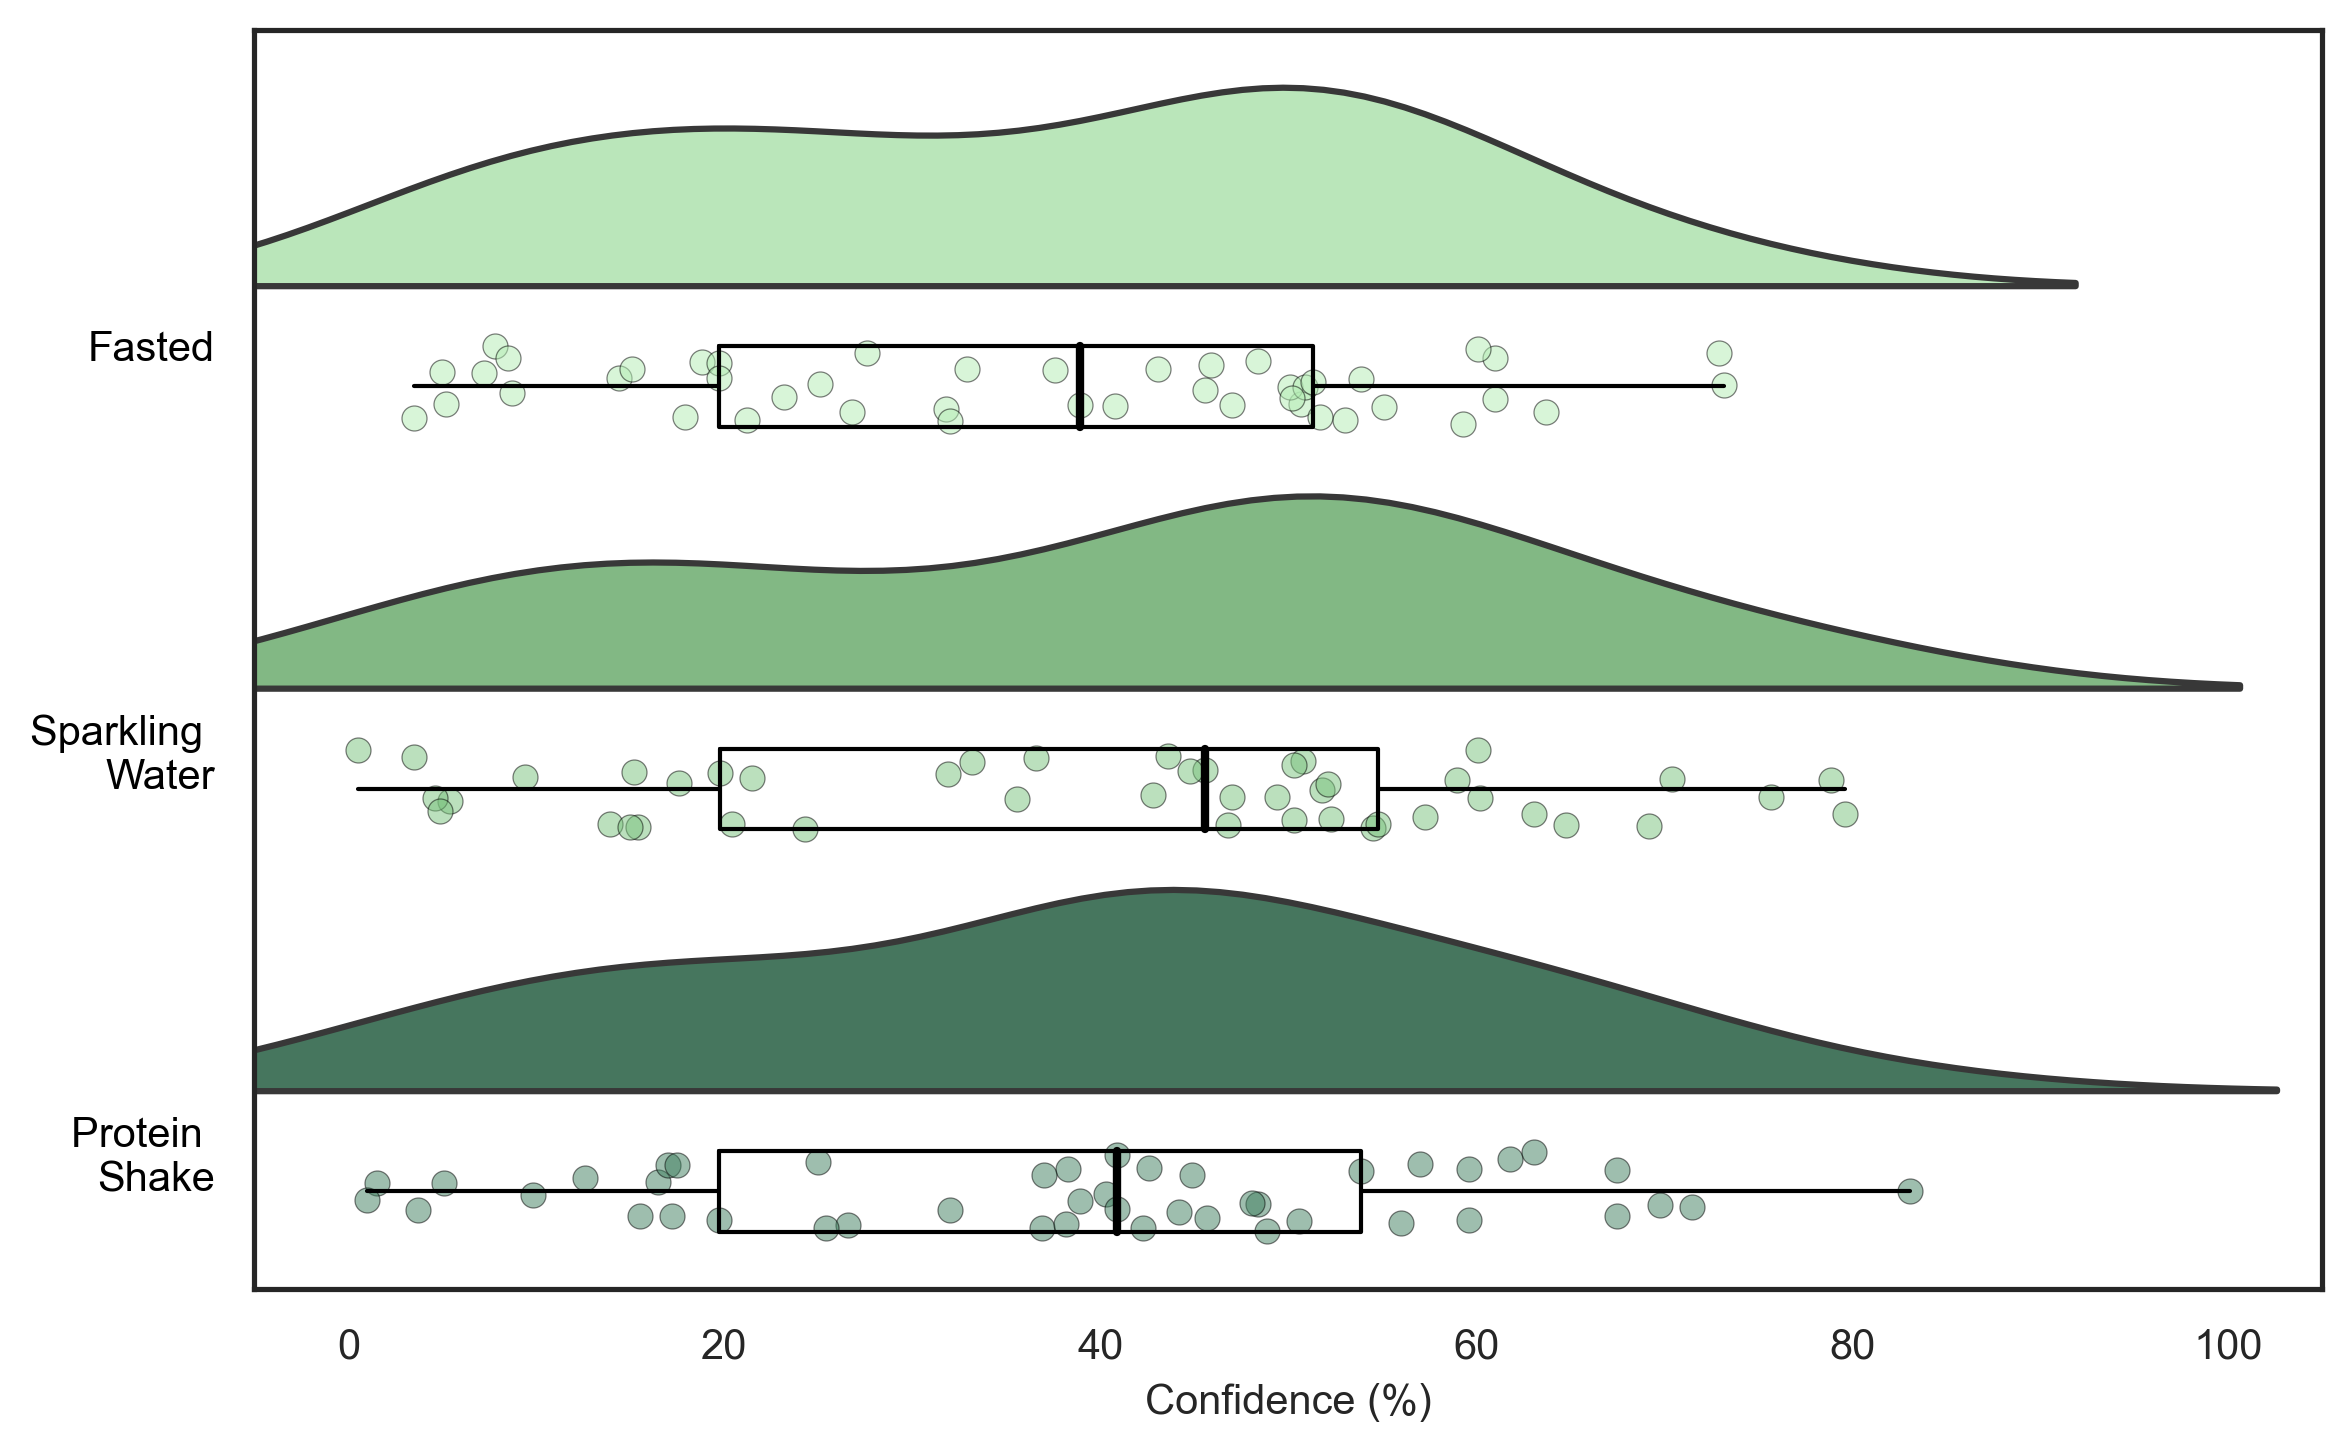

In [ ]:
# Ensure 'Condition' and 'Participant' are categorical
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], 
                                           categories=['fasted', 'sparkling_water', 'protein_shake'],
                                           ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

# Define a neutral green color palette
condition_palette = {
    'fasted':  (0.702, 0.929, 0.702) ,        # Dark green (scientific & muted)
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake':   (0.243, 0.494, 0.369)# Soft, light green (neutral)
}

# Create the figure
fig, ax = plt.subplots(figsize=(8, 5), dpi = 300)

# Half violin plot (raincloud plot)
pt.half_violinplot(
    x="Confidence", y="Condition", scale="area", 
    palette=condition_palette, inner=None, data=accuracy_df, width=1,
    ax=ax
)

# Add individual data points as scatter plot
for i, condition in enumerate(accuracy_df['Condition'].unique()):
    data = accuracy_df[accuracy_df["Condition"] == condition]
    y = i + np.random.uniform(high=0.2, size=len(data))  # Add some jitter
    x = data["Confidence"]
    ax.scatter(x, y, color=condition_palette[condition], alpha=0.5, edgecolor='black', linewidth=0.3)

# Positions for boxplot
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT]

# Boxplot for each condition (add median line and adjust appearance)
medianprops = dict(color='black', linewidth=2)
boxprops = dict(color='black', linewidth=1)

# Calculate the boxplot data
boxplot_data = [
    accuracy_df[accuracy_df['Condition'] == condition]['Confidence'].values
    for condition in accuracy_df['Condition'].unique()
]

ax.boxplot(
    boxplot_data, 
    vert=False, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False,  # Hide the outliers
    showcaps=False,    # Hide the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.2 
)

# Add labels and title
ax.set_xlabel("Confidence (%)", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_yticklabels(['Fasted', 'Sparkling \nWater', 'Protein \nShake'], fontsize=10,  color='black')
ax.set_xlim(-5,105)

# Change size of tick labels
ax.tick_params(labelsize=10)

# Show the plot
plt.tight_layout()
plt_name = 'Confidence_by_Condition.png'
plt_save_path = save_dir + '/' + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches='tight')
plt.show()


## BEHAVIOUR: ACCURACY X CONFIDENCE: 

In [ ]:
import pandas as pd
from pymer4.models import Lmer
from statsmodels.stats.multitest import multipletests

# Ensure Participant is treated as a categorical variable
accuracy_df['Participant'] = accuracy_df['Participant'].astype('category')

# Fit the final model with Participant as a random intercept
md = Lmer("Confidence ~ Accuracy_percent + Condition + Accuracy_percent:Condition + (1|Participant)", data=accuracy_df)
md.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})

print(md.summary())

summary = md.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append(('Conf_acc_cond_accxcond', row.name, row['P-val']))  # 'name' is the index, which is the predictor


Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Accuracy_percent+Condition+Accuracy_percent:Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -535.255 	 AIC: 1086.509

Random effects:

                    Name      Var     Std
Participant  (Intercept)  338.937  18.410
Residual                   66.611   8.162

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Accuracy_percent+Condition+Accuracy_percent:Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 135	 Groups: {'Participant': 45.0}

Log-likelihood: -535.255 	 AIC: 1086.509

Random effects:

                    Name      Var     Std
Participant  (Intercept)  338.937  18.410
Residual                   66.611   8.162

No random effect correlations specified

Fixed effects:

                             Estimate  2.5_c

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\3338700839.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_accuracy = accuracy_df.groupby('Participant')['Accuracy_percent'].mean().reset_index()
C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\3338700839.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall_confidence = accuracy_df.groupby('Participant')['Confidence'].mean().reset_index()


Overall Pearson Correlation between Confidence and Overall Accuracy: 0.28
P-value: 0.001

Fasted Condition:
 Pearson Correlation: 0.28
 P-value: 0.060

Sparkling_water Condition:
 Pearson Correlation: 0.33
 P-value: 0.025

Protein_shake Condition:
 Pearson Correlation: 0.22
 P-value: 0.152


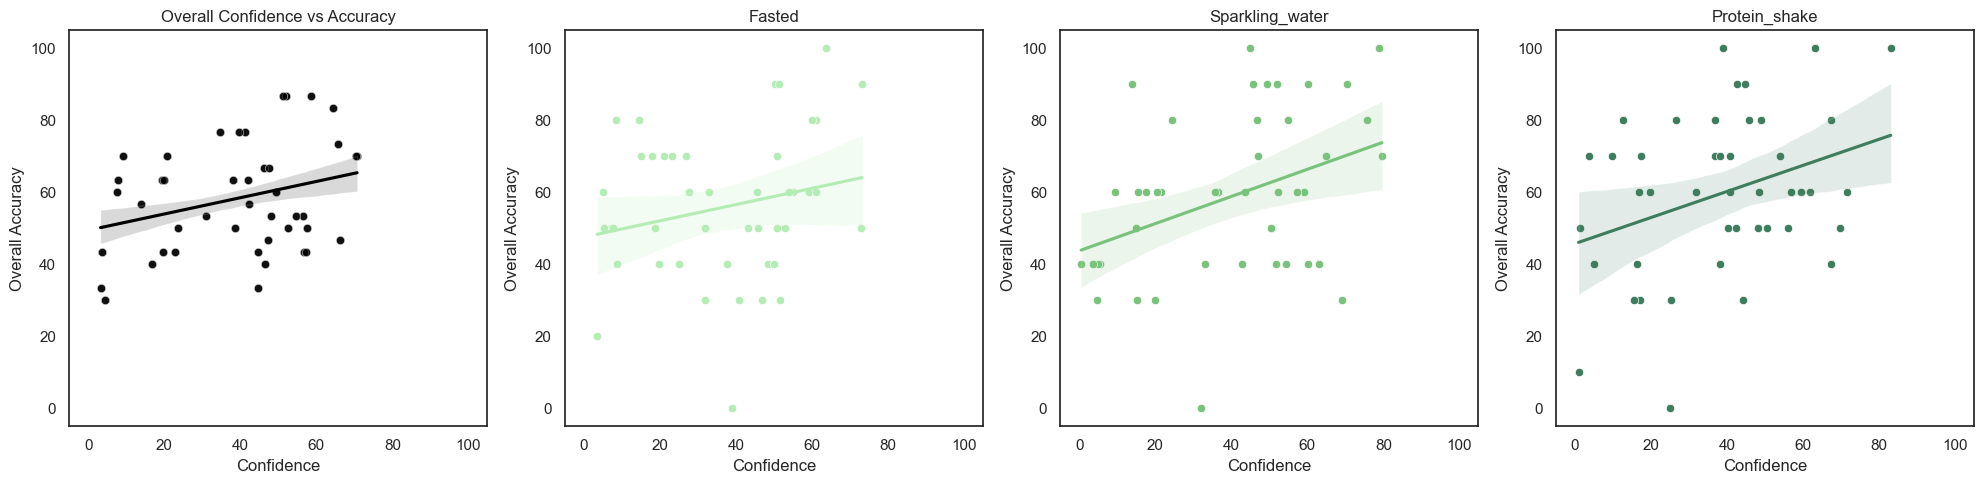

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### CALCULATE OVERALL TASK PERFORMANCE
# Calculate the overall accuracy for each participant
overall_accuracy = accuracy_df.groupby('Participant')['Accuracy_percent'].mean().reset_index()
overall_confidence = accuracy_df.groupby('Participant')['Confidence'].mean().reset_index()
overall_accuracy.columns = ['Participant', 'Overall_Accuracy']
overall_confidence.columns = ['Participant', 'Overall_Confidence']

# Merge the overall accuracy with the original dataframe
df_merged = accuracy_df.merge(overall_accuracy, on='Participant', how='left')
df_merged = df_merged.merge(overall_confidence, on='Participant', how='left')

# Display the merged dataframe (optional)
# display(HTML(df_merged.to_html()))


### CORRELATION ANALYSIS
# Calculate the overall Pearson correlation between Confidence and Overall Accuracy
overall_correlation, overall_p_value = pearsonr(df_merged['Confidence'], df_merged['Overall_Accuracy'])

# Print the overall correlation results
print(f'Overall Pearson Correlation between Confidence and Overall Accuracy: {overall_correlation:.2f}')
print(f'P-value: {overall_p_value:.3f}')

# Dictionary to store condition-wise correlation results
condition_results = {}

# Loop through each condition and calculate the Pearson correlation
for condition in accuracy_df['Condition'].unique():
    # Filter the data for the current condition
    condition_data = df_merged[df_merged['Condition'] == condition]
    
    # Calculate the correlation for the current condition
    condition_correlation, condition_p_value = pearsonr(condition_data['Confidence'], condition_data['Overall_Accuracy'])
    
    # Store results in dictionary
    condition_results[condition] = (condition_correlation, condition_p_value)
    
    # Print the correlation results for each condition
    print(f'\n{condition.capitalize()} Condition:')
    print(f' Pearson Correlation: {condition_correlation:.2f}')
    print(f' P-value: {condition_p_value:.3f}')


### PLOT
# Create a 1x4 subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
axes = axes.flatten()

# Define the conditions for plotting
conditions = ['fasted', 'sparkling_water', 'protein_shake']
condition_palette = {
    'fasted': (0.702, 0.929, 0.702),        # Dark green (scientific & muted)
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake': (0.243, 0.494, 0.369)  # Soft, light green (neutral)
}

# Overall correlation plot (first subplot)
sns.scatterplot(data=df_merged, x='Overall_Confidence', y='Overall_Accuracy', ax=axes[0], color='black', alpha=0.6)
sns.regplot(data=df_merged, x='Overall_Confidence', y='Overall_Accuracy', ax=axes[0], scatter=False, color='black')

axes[0].set_title('Overall Confidence vs Accuracy')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_xlim(-5, 105)
axes[0].set_ylim(-5, 105)

# Loop through each condition to plot the data
for i, condition in enumerate(conditions):
    condition_data = df_merged[df_merged['Condition'] == condition]
    color = condition_palette[condition]

    # Scatterplot
    sns.scatterplot(data=condition_data, x='Confidence', y='Accuracy_percent', ax=axes[i+1], alpha=1.0, color=color, legend=None)

    # Regression line
    sns.regplot(
        data=condition_data, x='Confidence', y='Accuracy_percent', ax=axes[i+1], 
        scatter=False, line_kws={'color': color}
    )

    axes[i+1].set_title(f'{condition.capitalize()}')
    axes[i+1].set_xlabel('Confidence')
    axes[i+1].set_ylabel('Overall Accuracy')
    axes[i+1].set_xlim(-5, 105)
    axes[i+1].set_ylim(-5, 105)

    # Print condition correlation results above each subplot
    #corr_value, p_value = condition_results[condition]
    #axes[i+1].text(50, 95, f'r = {corr_value:.2f}\np = {p_value:.3f}', 
    #               fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.5))

# Adjust the layout
plt.tight_layout()
plt_name = "Correlation_acc_conf.png"
plt_save_path = save_dir + "/" + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches="tight")
plt.show()


      Trial  Participant_Sound_Loc   Button  Response_code  Confidence  \
0         0                      1  Sound 2              2          10   
1         1                      1  Sound 1              1           1   
2         2                      1  Sound 1              1          74   
3         3                      2  Sound 2              2          88   
4         4                      1  Sound 1              1          92   
...     ...                    ...      ...            ...         ...   
1345     25                      1  Sound 1              1          66   
1346     26                      2  Sound 2              2          50   
1347     27                      2  Sound 2              2          12   
1348     28                      2  Sound 1              1          54   
1349     29                      2  Sound 2              2          28   

          Condition  Correct  Incorrect  
0            fasted        0          1  
1            fasted        


Fasted Condition:
U-statistic: 29654.5, P-value: 0.0006359421069166253


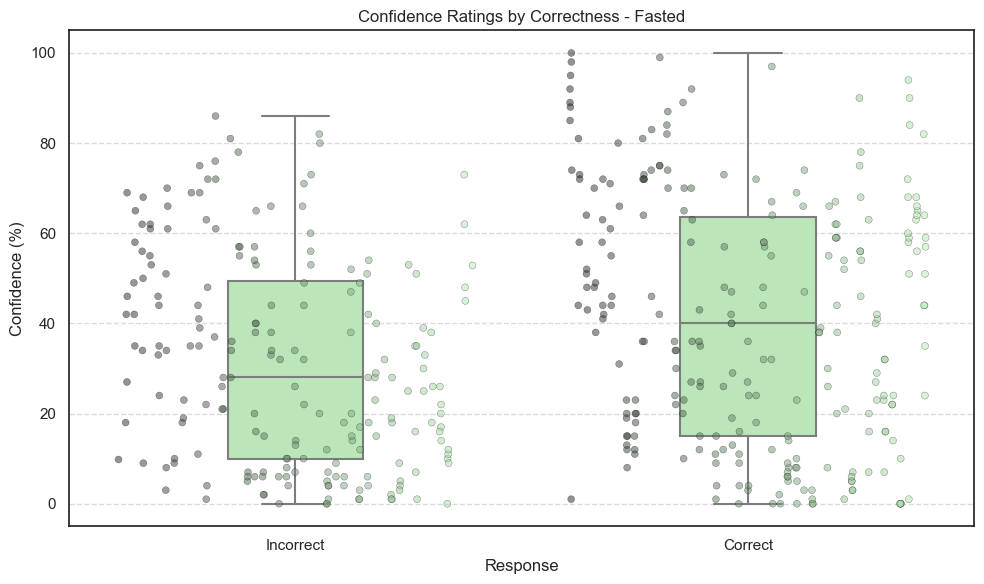


Sparkling_water Condition:
U-statistic: 29933.0, P-value: 6.511625653399258e-05


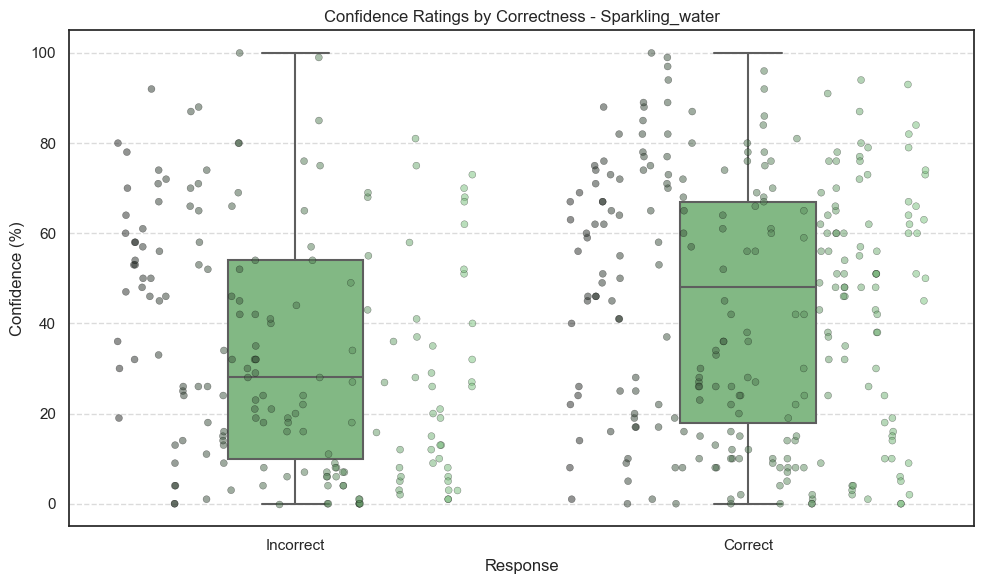


Protein_shake Condition:
U-statistic: 29059.5, P-value: 0.0004911530595690388


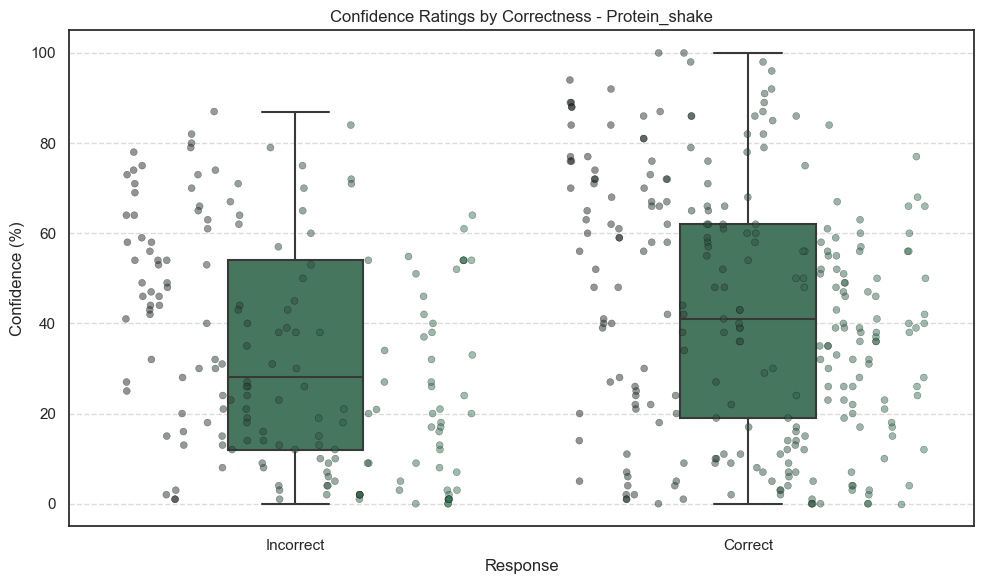

In [ ]:
import os
import pandas as pd
import numpy as np

# Specify the folder containing your .tsv files
folder_path = ''  # Update with your folder path
save_dir = '' # Update with your desired save directory

# Load all TSV files from the specified directory
data = []
file_names = []  # To store the participant IDs based on filenames
for filename in os.listdir(folder_path):
    if filename.endswith("gastric_stethoscope.tsv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t', header=1)  # Skip the first row (header)

        # Filter rows where 'Trial' is not numeric
        df = df[df['Trial'].str.isnumeric()]  # Keep only rows where 'Trial' is numeric
        df['Trial'] = df['Trial'].astype(int)  # Convert 'Trial' to integers
        df['Participant_Sound_Loc'] = df['Participant_Sound_Loc'].astype(int)
        df['Response_code'] = df['Response_code'].astype(int)
        df['Confidence'] = df['Confidence'].astype(int)
        
        # Exclude rows above the first instance where Trial = 0
        first_trial_zero_idx = df[df['Trial'] == 0].index.min()
        if not pd.isna(first_trial_zero_idx):
            df = df.loc[first_trial_zero_idx:]

        data.append(df)

        # Extract the participant ID from the filename (assuming the format "sub-XXX_gastric_stethascope.tsv")
        participant_id = filename.split('_')[0]  # Get the part before the first underscore (sub-XXX)
        file_names.append(participant_id)

# Concatenate all data into a single DataFrame
df = pd.concat(data, ignore_index=True)

# Add a new column for participant ID (from the filename)
# Remove 'sub-' prefix from filenames if present
cleaned_file_names = [name.replace('sub-', '') for name in file_names]

# Add condition labels based on trial ranges (0-9, 10-19, 20-29)
df['Condition'] = pd.cut(df['Trial'], bins=[-1, 9, 19, 29], labels=['fasted', 'sparkling_water', 'protein_shake'])

# Add 'Correct' column: 1 if the answer is correct, 0 if incorrect
df['Correct'] = (df['Participant_Sound_Loc'] == df['Response_code']).astype(int)

# Add 'Incorrect' column: 1 if the answer is incorrect, 0 if correct
df['Incorrect'] = (df['Participant_Sound_Loc'] != df['Response_code']).astype(int)

# Display the DataFrame with the added columns
print(df)  # Just to check the first few rows

# Optionally, save the updated DataFrame to a new file
# df.to_csv('./updated_data.csv', index=False)



# Add the cleaned participant IDs to the DataFrame
df['Participant'] = np.repeat(cleaned_file_names, [len(data[i]) for i in range(len(data))])
display(HTML(df.head().to_html()))
# Define the color palette for each condition
condition_palette = {
    'fasted': (0.702, 0.929, 0.702),        # Dark green
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake': (0.243, 0.494, 0.369)   # Soft, light green
}

# Loop through each condition and perform the analysis and plot
conditions = df['Condition'].unique()

for condition in conditions:
    # Filter data for the current condition
    condition_data = df[df['Condition'] == condition]

    # Separate confidence ratings for correct and incorrect responses
    correct_confidence = condition_data[condition_data['Correct'] == 1]['Confidence']
    incorrect_confidence = condition_data[condition_data['Correct'] == 0]['Confidence']

    # Perform the Mann-Whitney U test (non-parametric test for confidence comparison)
    U_stat, p_value = mannwhitneyu(correct_confidence, incorrect_confidence)

    # Output the results for the current condition
    print(f"\n{condition.capitalize()} Condition:")
    print(f"U-statistic: {U_stat}, P-value: {p_value}")

    # Create the plot for the current condition
    plt.figure(figsize=(10, 6))
    sns.set(style="white")

    # Swarmplot with participant grouping
    sns.stripplot(x='Correct', y='Confidence', hue='Participant', data=condition_data, dodge=True, alpha=0.5, edgecolor='black', linewidth=0.3, color = condition_palette[condition])

    # Add a boxplot for overall summary
    sns.boxplot(x='Correct', y='Confidence', data=condition_data, palette=[condition_palette[condition]] * 2, showfliers=False, width=.3)

    # Set plot title and labels
    plt.title(f'Confidence Ratings by Correctness - {condition.capitalize()}')
    plt.xticks([0, 1], ['Incorrect', 'Correct'])
    plt.xlabel('Response')
    plt.ylabel('Confidence (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add the legend for participants
    #plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend([], [], frameon=False)  # This disables the legend

    # Show the plot
    plt.tight_layout()
    plt_name = f"Acc_conf_{condition}.png"
    plt_save_path = save_dir + "/" + plt_name
    plt.savefig(plt_save_path, dpi=300, bbox_inches="tight")
    plt.show()


c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.p

    Participant      Condition       AUC
0           004         fasted  0.888889
1           006         fasted  0.880000
2           007         fasted  0.560000
3           008         fasted  0.500000
4           011         fasted  0.416667
..          ...            ...       ...
130         136  protein_shake  0.619048
131         138  protein_shake  0.111111
132         140  protein_shake  0.809524
133         141  protein_shake  0.500000
134         142  protein_shake  0.458333

[135 rows x 3 columns]


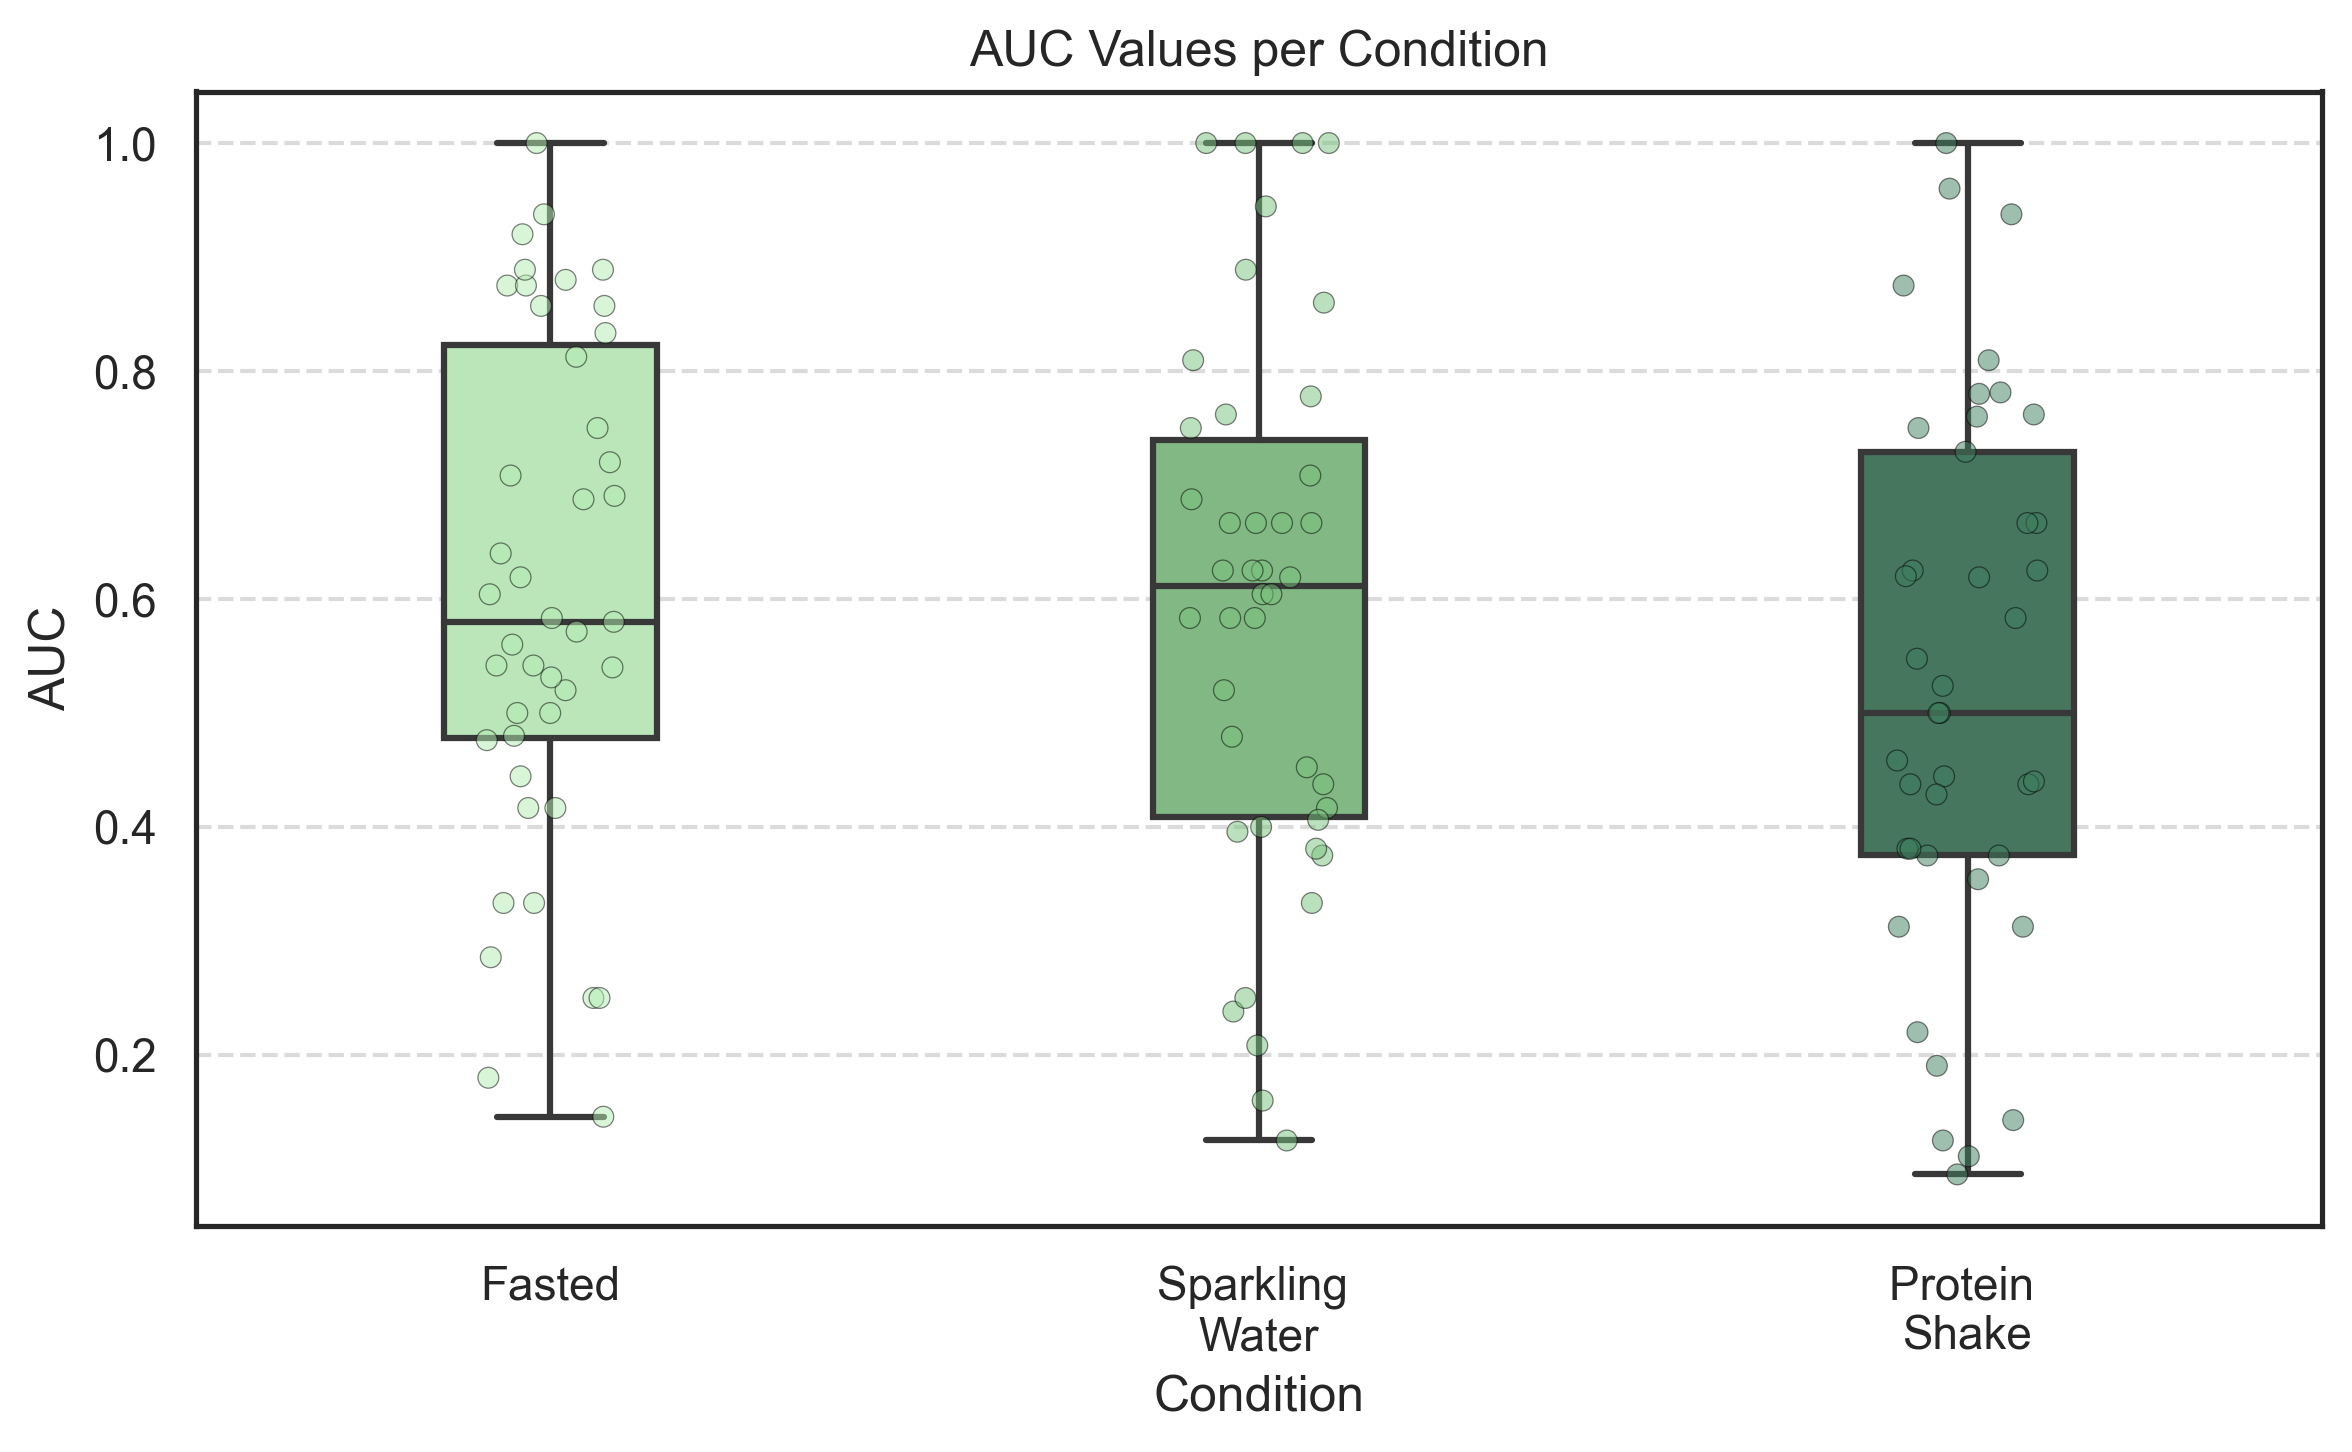

In [ ]:

# Function to calculate ROC curve and AUC for metacognitive awareness in the gastric task per condition
def calculate_metacognitive_awareness(df):
    conditions = df['Condition'].unique()
    roc_results = {}
    
    for condition in conditions:
        condition_data = df[df['Condition'] == condition]
        participants = condition_data['Participant'].unique()
        
        for participant in participants:
            participant_data = condition_data[condition_data['Participant'] == participant].copy()
            participant_data.loc[:, 'Accuracy'] = (participant_data['Participant_Sound_Loc'] == participant_data['Response_code']).astype(int)
            
            y_true = participant_data['Accuracy']
            y_scores = participant_data['Confidence']
            
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            roc_results[(participant, condition)] = {'roc_auc': roc_auc}
    
    return roc_results

# Compute ROC results
roc_results = calculate_metacognitive_awareness(df)

# Store AUC values in a DataFrame
auc_data = [{'Participant': participant, 'Condition': condition, 'AUC': results['roc_auc']} 
            for (participant, condition), results in roc_results.items()]
df_auc = pd.DataFrame(auc_data)

# Merge AUC values into original df
df['Participant'] = df['Participant'].astype(str)
df_auc['Participant'] = df_auc['Participant'].astype(str)
print(df_auc)
df_merged = pd.merge(df, df_auc, on=['Participant', 'Condition'], how='left')
df_merged = df_merged.dropna(subset=['AUC', 'Participant']) #drop participants with NAN
#print(df_merged)

# Create AUC visualization
plt.figure(figsize=(8, 5), dpi=300)
sns.set(style="white")

# Stripplot of AUC per condition
sns.stripplot(x='Condition', y='AUC', data=df_auc, dodge=True, alpha=0.5, edgecolor='black', linewidth=0.3, palette=condition_palette)

# Boxplot for summary statistics
sns.boxplot(x='Condition', y='AUC', data=df_auc, showfliers=False, width=.3, palette=condition_palette)

# Formatting the plot
plt.title('AUC Values per Condition')
plt.xlabel('Condition')
plt.xticks([0, 1,2], ['Fasted', 'Sparkling \nWater', 'Protein \nShake'])

plt.ylabel('AUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([], [], frameon=False)  # Disable the legend

# Save and show plot
plt.tight_layout()
plt.savefig("AUC_per_condition.png", dpi=300, bbox_inches="tight")
plt.show()



c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[array([0.88888889, 0.88      , 0.56      , 0.5       , 0.41666667,
       0.92      , 0.69047619, 0.875     , 0.33333333, 0.8125    ,
       0.85714286, 0.875     , 0.72      , 0.83333333, 0.41666667,
       0.54166667, 1.        ,        nan, 0.58      , 0.52      ,
       0.85714286, 0.54      , 0.48      , 0.47619048, 0.25      ,
       0.33333333, 0.25      , 0.53125   , 0.61904762, 0.6875    ,
       0.14583333, 0.57142857, 0.64      , 0.88888889, 0.75      ,
       0.5       , 0.9375    , 0.54166667, 0.58333333, 0.28571429,
       0.60416667, 0.18      ,        nan, 0.70833333, 0.44444444]), array([0.41666667, 0.16      , 0.58333333, 0.66666667, 0.61904762,
       0.39583333, 0.40625   , 0.60416667, 0.4375    , 0.76190476,
       0.60416667, 0.625     ,        nan, 0.23809524, 0.66666667,
       0.66666667, 0.125     ,        nan, 0.70833333, 0.80952381,
       0.94444444, 0.58333333, 0.6875    , 0.75      , 1.        ,
       0.20833333, 0.45238095, 0.625     , 1.        , 0.58

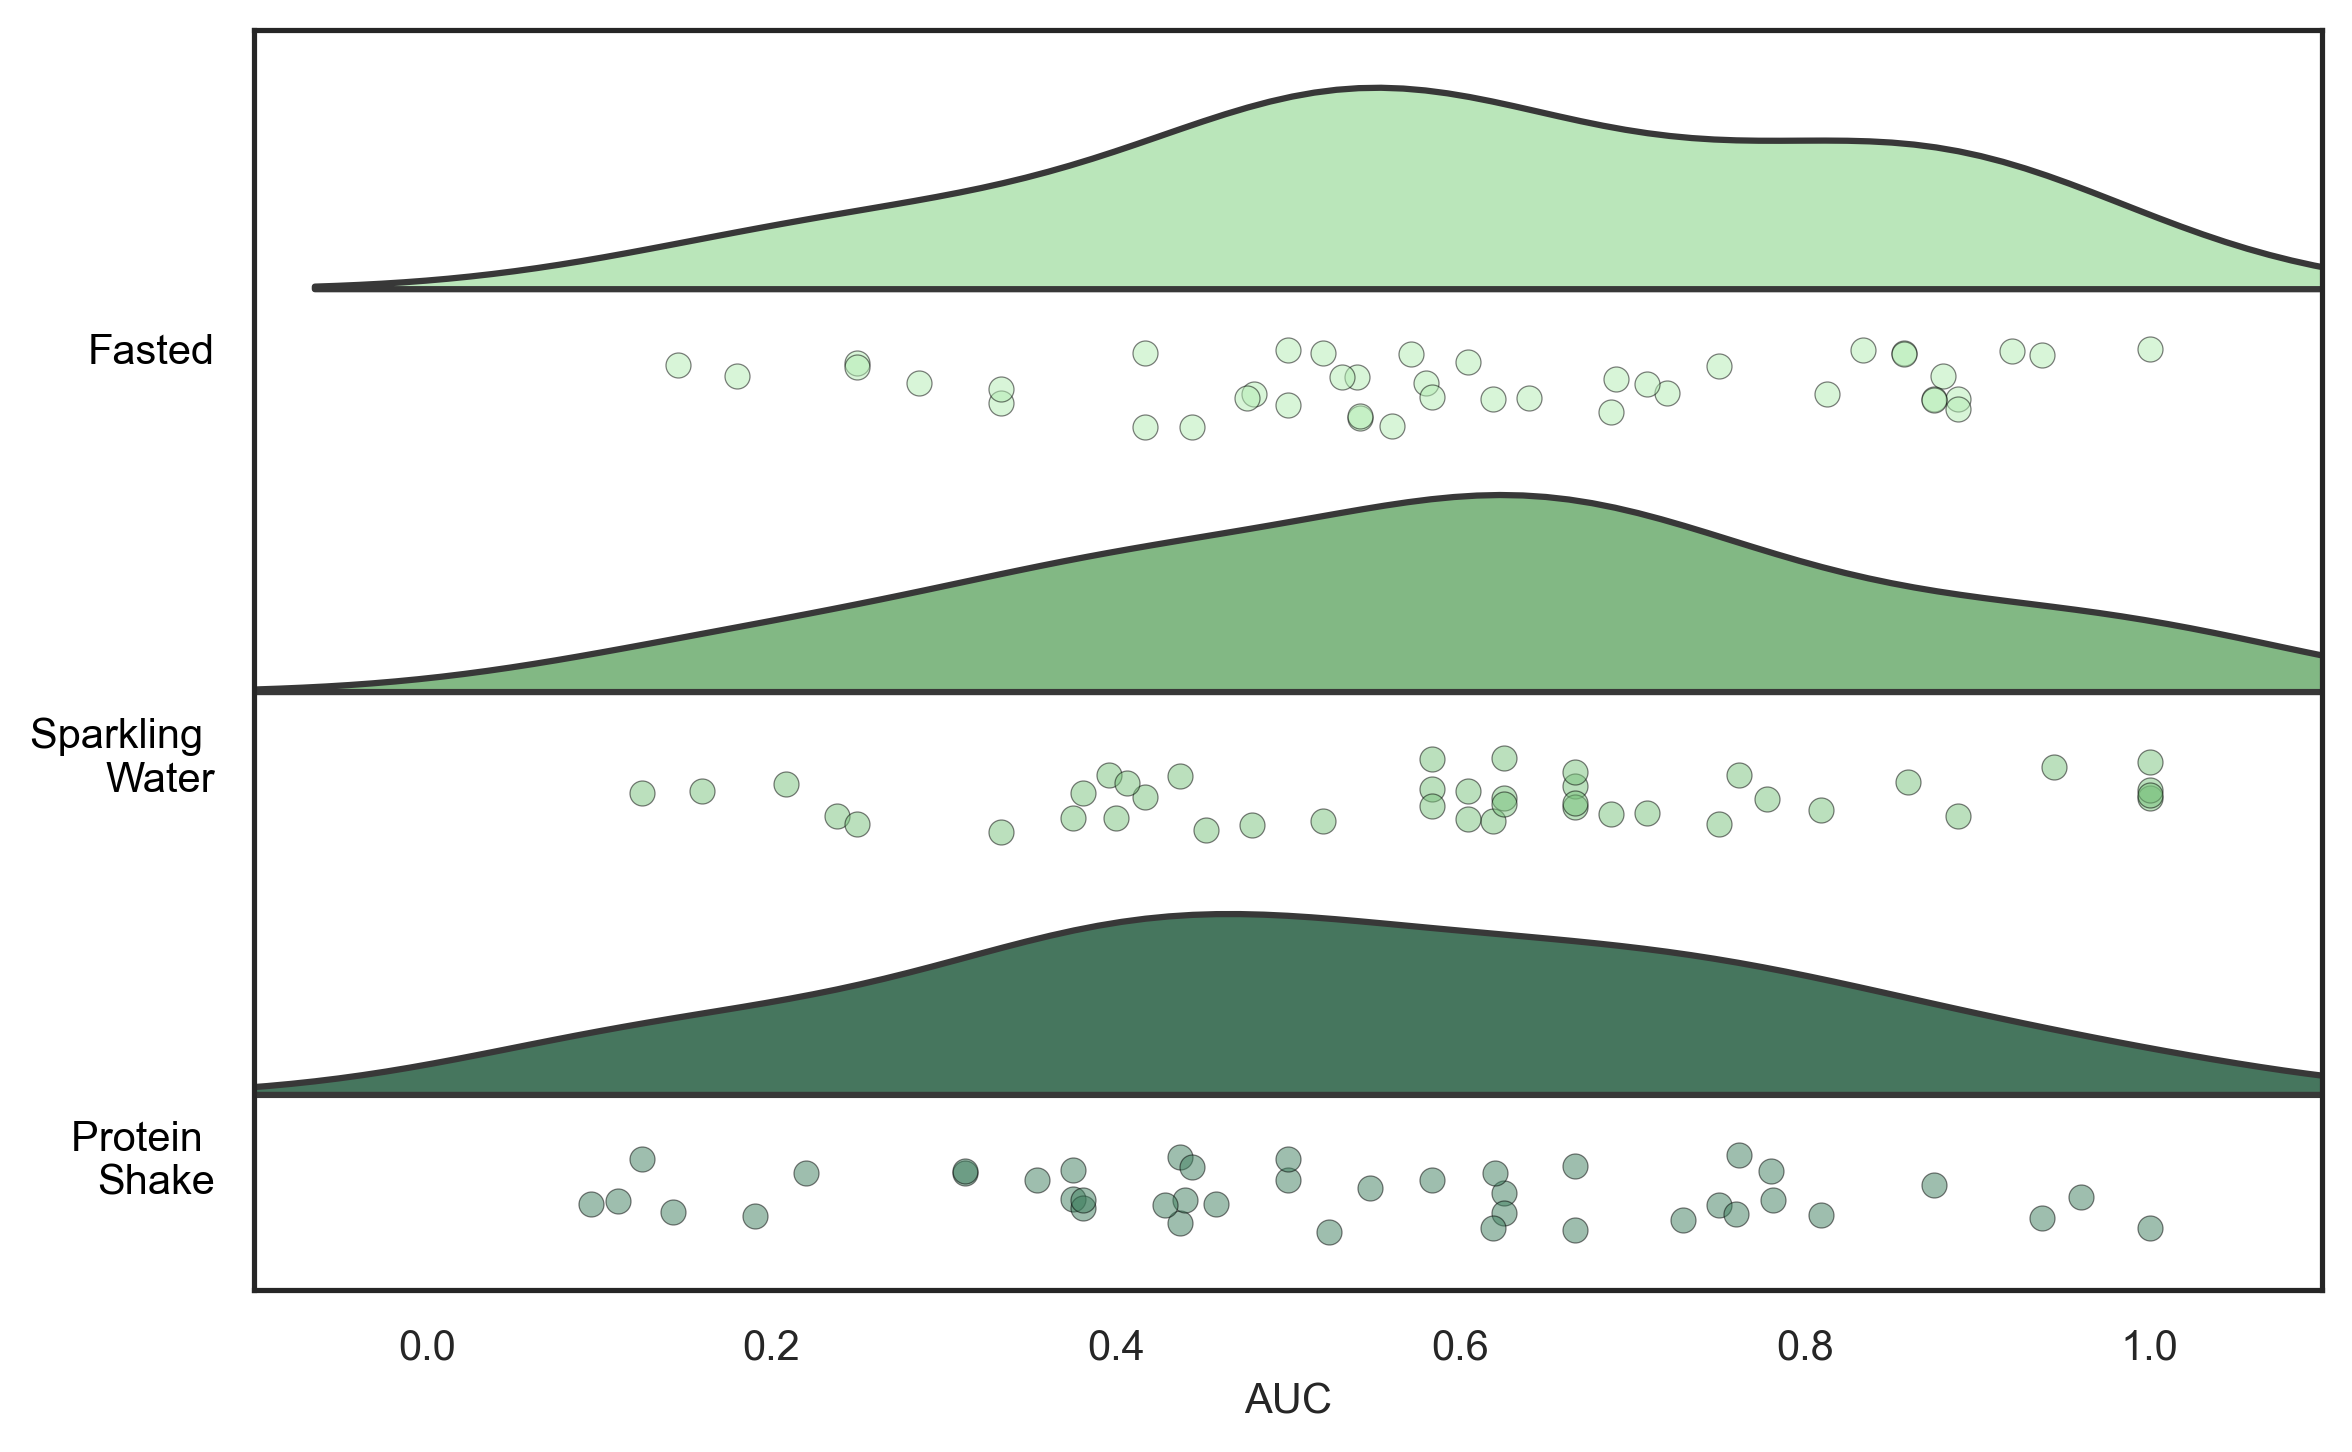

In [ ]:
# Ensure 'Condition' and 'Participant' are categorical
df_auc['Condition'] = pd.Categorical(df_auc['Condition'], 
                                           categories=['fasted', 'sparkling_water', 'protein_shake'],
                                           ordered=True)
df_auc['Participant'] = pd.Categorical(df_auc['Participant'])

# Define a neutral green color palette
condition_palette = {
    'fasted':  (0.702, 0.929, 0.702) ,        # Dark green (scientific & muted)
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake':   (0.243, 0.494, 0.369)# Soft, light green (neutral)
}

# Create the figure
fig, ax = plt.subplots(figsize=(8, 5), dpi = 300)

# Half violin plot (raincloud plot)
pt.half_violinplot(
    x="AUC", y="Condition", scale="area", 
    palette=condition_palette, inner=None, data=df_auc, width=1,
    ax=ax
)

# Add individual data points as scatter plot
for i, condition in enumerate(df_auc['Condition'].unique()):
    data = df_auc[df_auc["Condition"] == condition]
    y = i + np.random.uniform(high=0.2, size=len(data))  # Add some jitter
    x = data["AUC"]
    ax.scatter(x, y, color=condition_palette[condition], alpha=0.5, edgecolor='black', linewidth=0.3)

# Positions for boxplot
SHIFT = 0.1
POSITIONS = [0 + SHIFT, 1 + SHIFT, 2 + SHIFT]

# Boxplot for each condition (add median line and adjust appearance)
medianprops = dict(color='black', linewidth=2)
boxprops = dict(color='black', linewidth=1)

# Calculate the boxplot data
boxplot_data = [
    df_auc[df_auc['Condition'] == condition]['AUC'].values
    for condition in df_auc['Condition'].unique()
]
print(boxplot_data)

ax.boxplot(
    boxplot_data, 
    vert=True, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False,  # Hide the outliers
    showcaps=False,    # Hide the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.3 
)

# Add labels and title
ax.set_xlabel("AUC", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_yticklabels(['Fasted', 'Sparkling \nWater', 'Protein \nShake'], fontsize=10,  color='black')

# Add a shaded area for accuracy >= 80%
ax.axvspan(80, 100, color='gray', alpha=0.1)  # Light gray shading with low opacity
ax.set_xlim(-0.1,1.1)

# Change size of tick labels
ax.tick_params(labelsize=10)

# Show the plot
plt.tight_layout()
plt_name = 'AUC_per_cond_horiz.png'
plt_save_path = save_dir + '/' + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Step 1: Drop rows with missing AUC values
df_auc = df_auc.dropna(subset=['AUC'])
df_auc.to_csv('AUC.csv')
# Step 2: Count the number of rows for each participant
participant_counts = df_auc['Participant'].value_counts()

# Step 3: Filter out participants who do not have exactly 3 rows
valid_participants = participant_counts[participant_counts == 3].index

# Step 4: Keep only rows from valid participants
df_auc = df_auc[df_auc['Participant'].isin(valid_participants)]
print(df_auc.describe())
print(df_auc.groupby('Condition').describe())

# Step 5: Mixed effects model analysis to compare AUC values across conditions
md = Lmer("AUC ~ Condition + (1|Participant)", data=df_auc)
md.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})

# Display the model results
print(md.summary())

summary = md.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append(('AUC_cond', row.name, row['P-val']))  # 'name' is the index, which is the predictor


              AUC
count  114.000000
mean     0.567675
std      0.231507
min      0.095238
25%      0.408854
50%      0.581667
75%      0.723958
max      1.000000
                  AUC                                                    \
                count      mean       std       min       25%       50%   
Condition                                                                 
fasted           38.0  0.581164  0.221268  0.145833  0.452381  0.550833   
sparkling_water  38.0  0.596779  0.227641  0.160000  0.414062  0.611607   
protein_shake    38.0  0.525082  0.244915  0.095238  0.375000  0.511905   

                                   
                      75%     max  
Condition                          
fasted           0.786458  0.9375  
sparkling_water  0.703125  1.0000  
protein_shake    0.713542  1.0000  


C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\4126706003.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_auc.groupby('Condition').describe())


Linear mixed model fit by REML [’lmerMod’]
Formula: AUC~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 114	 Groups: {'Participant': 38.0}

Log-likelihood: 0.977 	 AIC: 8.046

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.009  0.096
Residual                  0.044  0.211

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: AUC~Condition+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 114	 Groups: {'Participant': 38.0}

Log-likelihood: 0.977 	 AIC: 8.046

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.009  0.096
Residual                  0.044  0.211

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.581   0.508    0.655  0.038  104.781  15.476  0.000  ***
Condition1      0.016  -0.

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


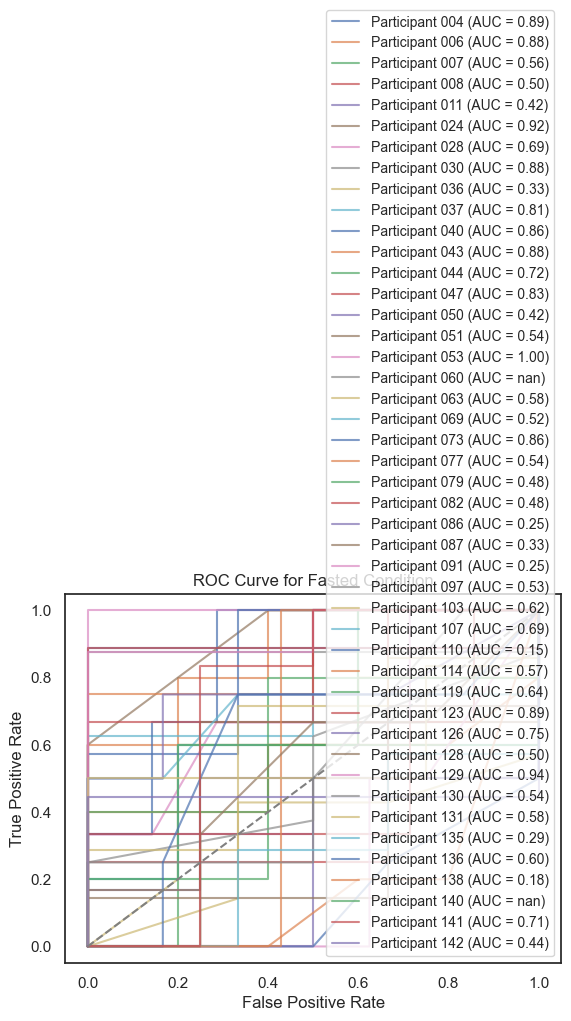

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


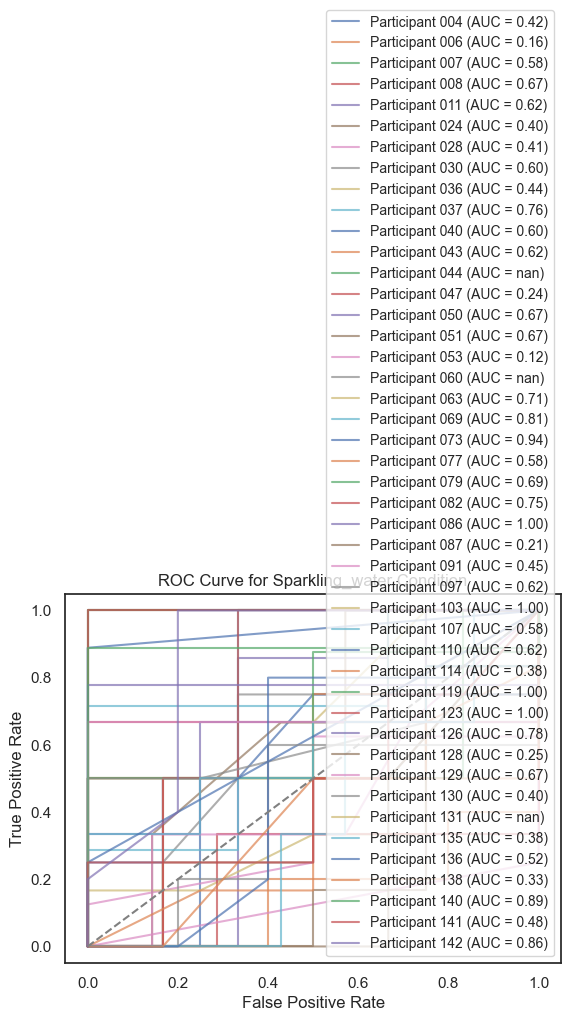

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


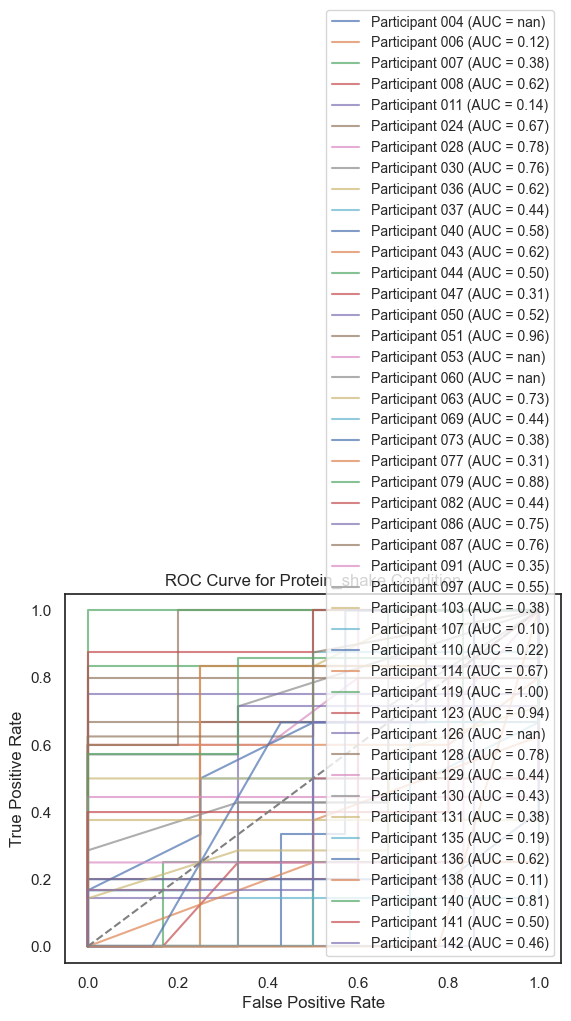

In [ ]:
# Function to calculate ROC curve and AUC for metacognitive awareness in the gastric task per condition
def calculate_metacognitive_awareness(df):
    conditions = df['Condition'].unique()
    
    # Store the ROC results
    roc_results = {}

    for condition in conditions:
        condition_data = df[df['Condition'] == condition]
        participants = condition_data['Participant'].unique()
        
        for participant in participants:
            # Subset data for the current participant and condition
            participant_data = condition_data[condition_data['Participant'] == participant].copy()

            # Calculate accuracy for each trial (1 = correct, 0 = incorrect)
            participant_data.loc[:, 'Accuracy'] = (participant_data['Participant_Sound_Loc'] == participant_data['Response_code']).astype(int)
            
            # Extract test variable (confidence) and state variable (accuracy)
            y_true = participant_data['Accuracy']
            y_scores = participant_data['Confidence']
            
            # Compute ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store ROC curve data and AUC for the participant
            roc_results[(participant, condition)] = {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'roc_auc': roc_auc
            }

            # Plot the ROC curve for the participant
            plt.plot(fpr, tpr, label=f'Participant {participant} (AUC = {roc_auc:.2f})', alpha=0.7)
        
        # Plot settings
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (random classifier)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {condition.capitalize()} Condition')
        plt.legend(loc='lower right', fontsize='small')
        plt.show()
    
    return roc_results

# Calculate and plot ROC curve and AUC for gastric task per condition
roc_results = calculate_metacognitive_awareness(df)

# Store AUC values
auc_data = [{'Participant': participant, 'Condition': condition, 'AUC': results['roc_auc']} 
            for (participant, condition), results in roc_results.items()]

# Convert to a DataFrame
df_auc = pd.DataFrame(auc_data)

# Ensure Participant IDs are the same type in both DataFrames
df['Participant'] = df['Participant'].astype(str)
df_auc['Participant'] = df_auc['Participant'].astype(str)

# Merge AUC values into df
df_merged = pd.merge(df, df_auc, on=['Participant', 'Condition'], how='left')

# Display the updated DataFrame
display(HTML(df_merged.to_html()))


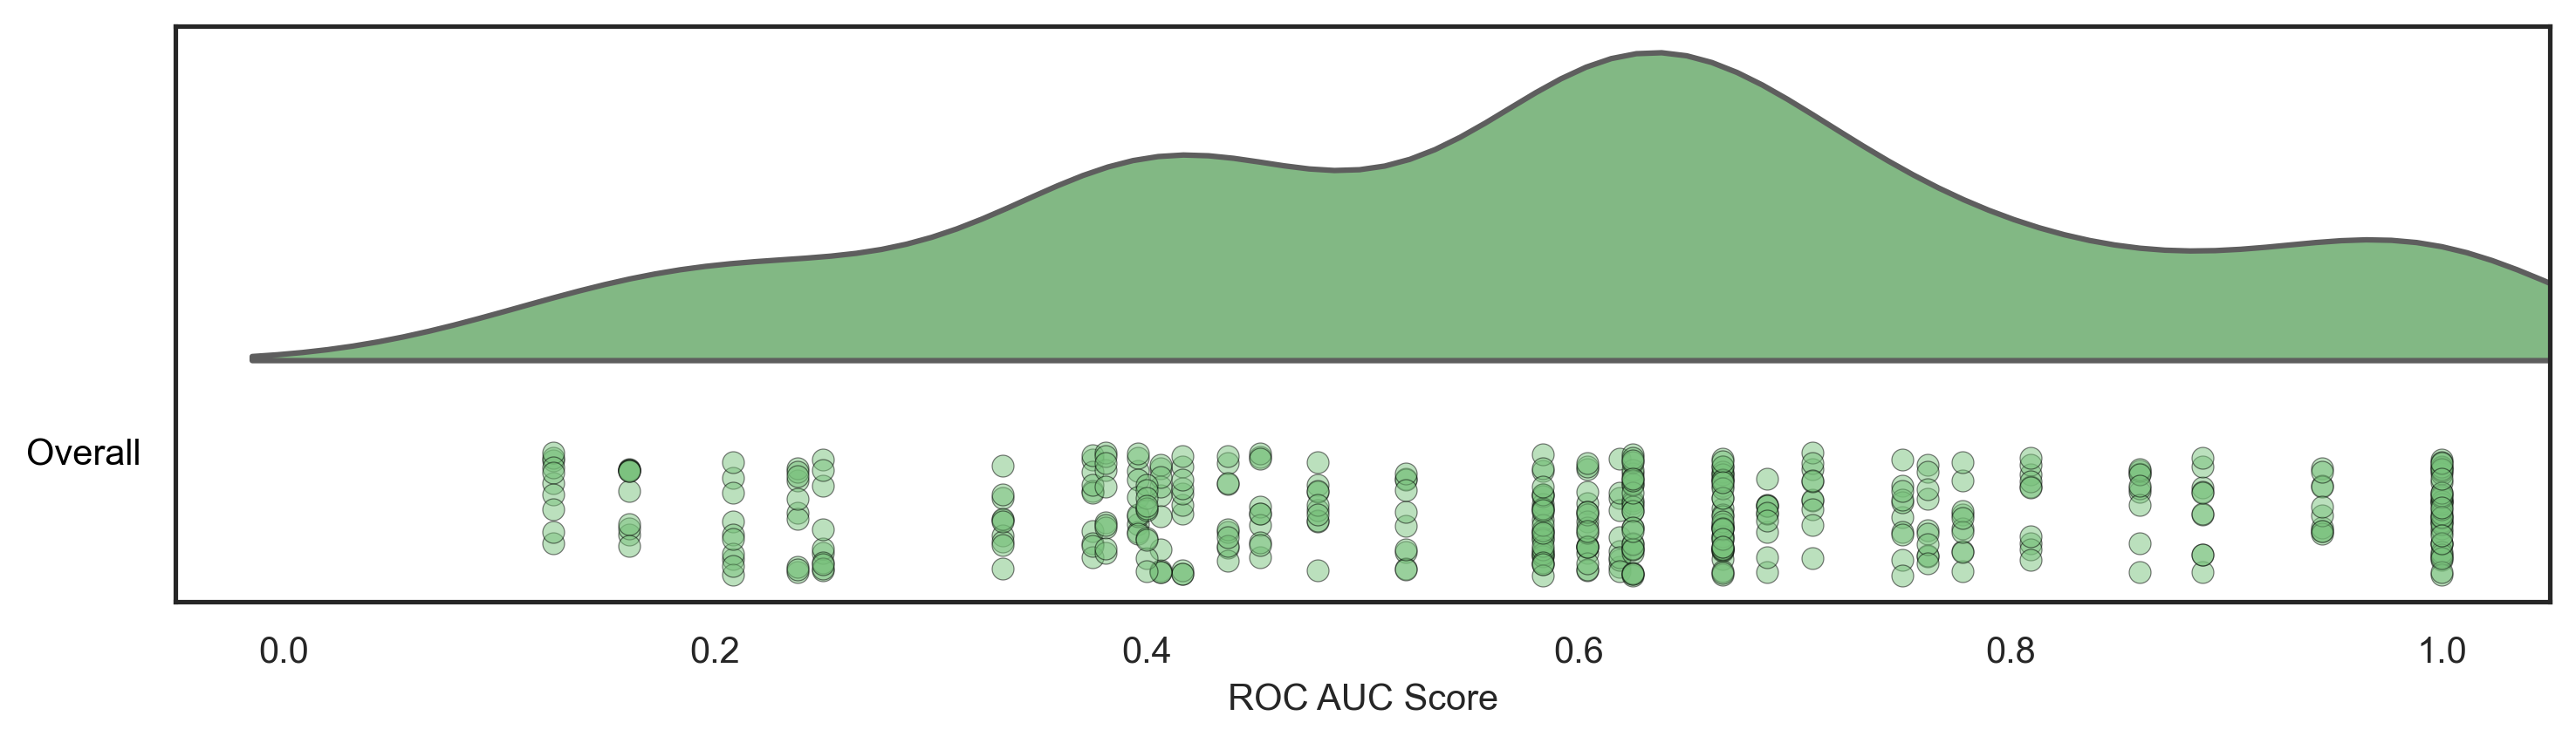

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Set up the plot style
sns.set(style="white")

# Create the figure
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
df_merged = df_merged[df_merged['Condition'] == 'sparkling_water'] #Filter by a single condition so as not to get triplicate values per participant

# Plot the half violin plot (raincloud plot) using the "roc_auc" from the entire dataset
pt.half_violinplot(
    x="AUC", scale="area", 
    color = (0.474, 0.759, 0.486),
    inner=None, data=df_merged, width=1,
    ax=ax
)

# Add individual data points as scatter plot
y = np.random.uniform(0, 0.2, size=len(df_merged))  # Add some jitter across all data
x = df_merged["AUC"]
ax.scatter(x, y, color=(0.474, 0.759, 0.486), alpha=0.5, edgecolor='black', linewidth=0.3)

# Boxplot for the entire data (using roc_auc)
SHIFT = 0.1
POSITIONS = [0 + SHIFT]

# Boxplot data for roc_auc
boxplot_data = df_merged['AUC'].values

# Add boxplot
medianprops = dict(color='black', linewidth=2)
boxprops = dict(color='black', linewidth=1)

ax.boxplot(
    [boxplot_data], 
    vert=False, 
    positions=POSITIONS, 
    manage_ticks=False,
    showfliers=False,  # Hide the outliers
    showcaps=False,    # Hide the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops,
    widths=0.2 
)

# Add labels and title
ax.set_xlabel("ROC AUC Score", fontsize=10)
ax.set_ylabel("", fontsize=10)
ax.set_yticklabels(['Overall'], fontsize=10,  color='black')
ax.set_xlim(-0.05, 1.05)

# Change size of tick labels
ax.tick_params(labelsize=10)

# Show the plot
plt.tight_layout()
plt_name = "Overall_AUC.png"
plt_save_path = save_dir + "/" + plt_name
plt.savefig(plt_save_path, dpi=300, bbox_inches="tight")
plt.show()

plt.show()


## BEHAVIOUR - SUBJECTIVE REPORTS: Plot data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Specify the folder containing your .tsv files
folder_path = ''  # Update with your folder path

# Load all TSV files from the specified directory
data = []
file_names = []  # To store the participant IDs based on filenames
for filename in os.listdir(folder_path):
    if filename.endswith("gastric_stethoscope.tsv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t', header=1, usecols = ['Trial', 'Participant_Sound_Loc', 'Button']) 
        # Filter and clean
        df = df[df['Trial'] == 'Question']
        df['Question_Type'] = df['Participant_Sound_Loc'].str.extract(r'([a-zA-Z]+)')  # Extract text
        df['Instance'] = df['Participant_Sound_Loc'].str.extract(r'(\d+)')  # Extract numbers as strings
        df['Instance'] = df['Instance'].fillna(1).astype(int)
        df['Button'] = df['Button'].astype(int)
        
        # Exclude rows above the first instance where Trial = 0
        first_trial_zero_idx = df[df['Trial'] == 0].index.min()
        if not pd.isna(first_trial_zero_idx):
            df = df.loc[first_trial_zero_idx:]

        data.append(df)

        # Extract the participant ID from the filename (assuming the format "sub-XXX_gastric_stethascope.tsv")
        participant_id = filename.split('_')[0]  # Get the part before the first underscore (sub-XXX)
        file_names.append(participant_id)

# Concatenate all data into a single DataFrame
df = pd.concat(data, ignore_index=True)

# Add a new column for participant ID (from the filename)
# Remove 'sub-' prefix from filenames if present
cleaned_file_names = [name.replace('sub-', '') for name in file_names]

# Add the cleaned participant IDs to the DataFrame
df['Participant'] = np.repeat(cleaned_file_names, [len(data[i]) for i in range(len(data))])
print(df)

        Trial Participant_Sound_Loc  Button Question_Type  Instance  \
0    Question               Hunger1      74        Hunger         1   
1    Question               Nausea1      33        Nausea         1   
2    Question             Disgust1       12       Disgust         1   
3    Question               Hunger2      56        Hunger         2   
4    Question               Nausea2      38        Nausea         2   
..        ...                   ...     ...           ...       ...   
760  Question           TaskGeneral      65   TaskGeneral         1   
761  Question            Difficulty      58    Difficulty         1   
762  Question             Gut_Norm       43           Gut         1   
763  Question          Drink1_Like       76         Drink         1   
764  Question          Drink2_Like       43         Drink         2   

    Participant  
0           004  
1           004  
2           004  
3           004  
4           004  
..          ...  
760         142  
761

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\1618236913.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for instance, instance_data in question_data.groupby('Instance'):
c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re

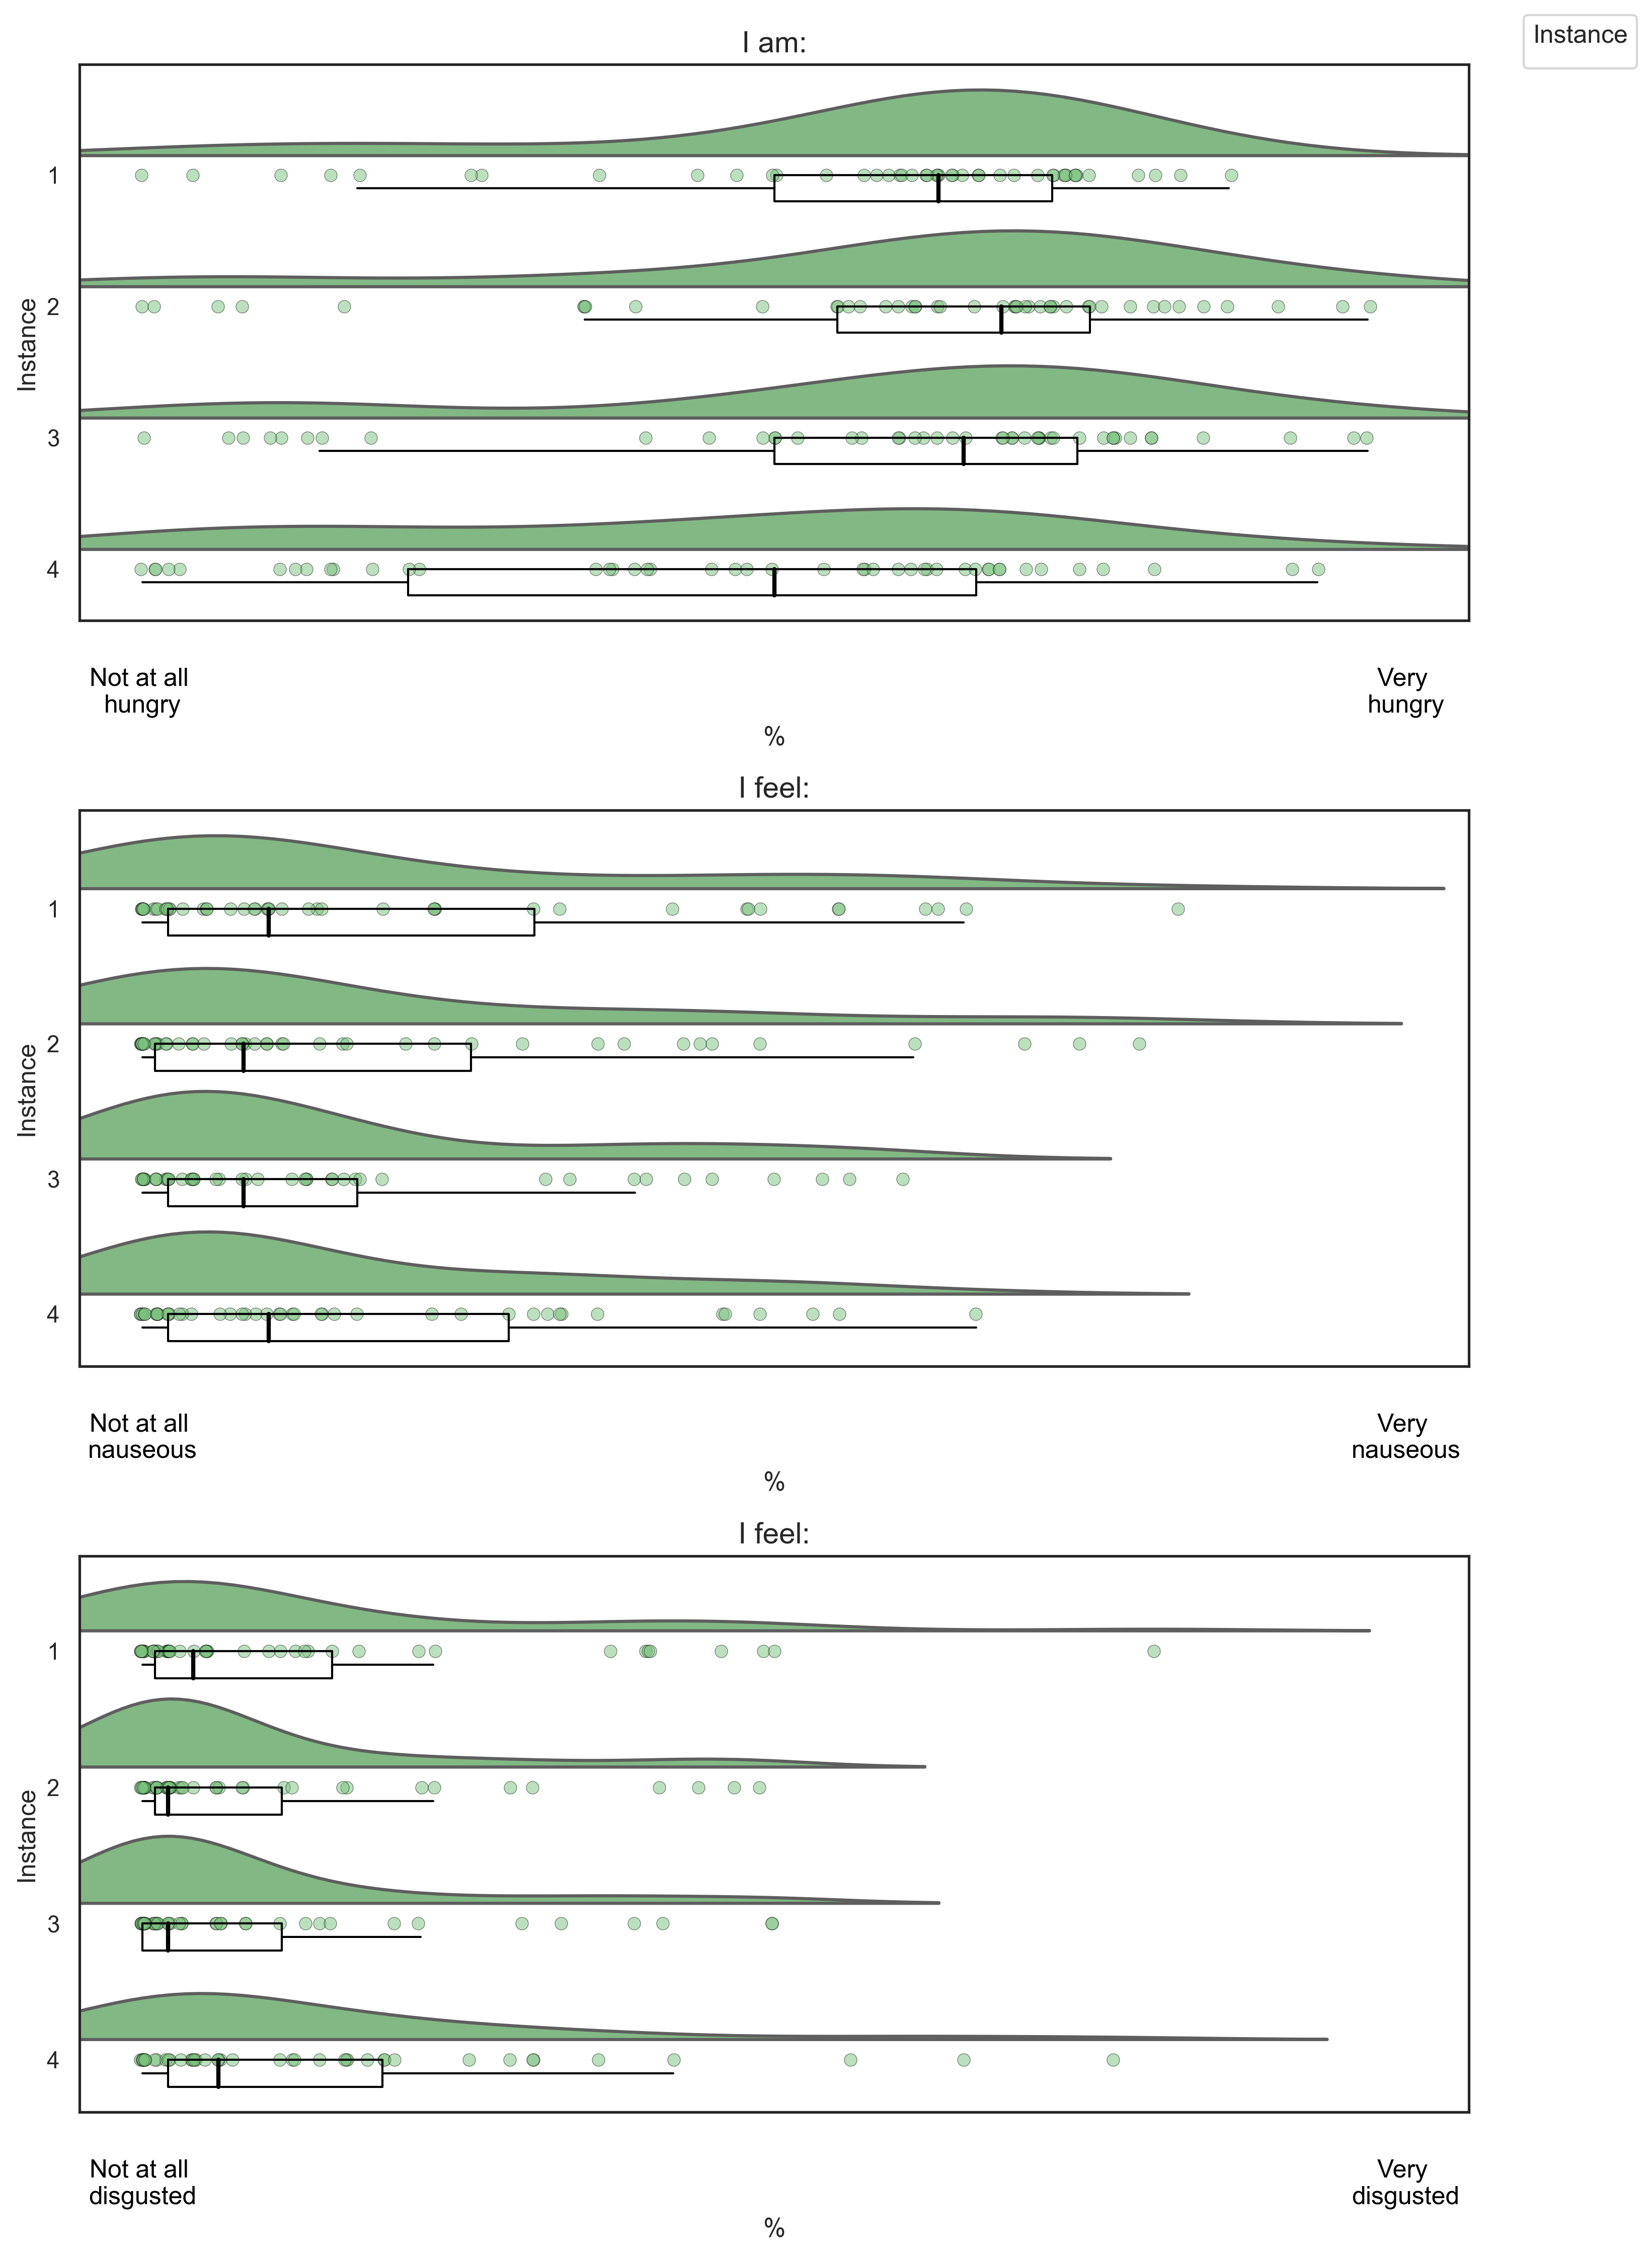

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ptitprince as pt
import numpy as np

# Get unique Question_Types
question_types = df['Question_Type'].unique()
question_types = ['Hunger', 'Nausea', 'Disgust']

# Set up the plot style
sns.set(style="white")
n = len(question_types)
cols = 1  
rows = len(question_types)  # Number of rows based on the number of Question_Types

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5), dpi = 300)
axes = axes.flatten()

# Define a neutral green color palette
fixed_palette = sns.color_palette("Greens", 5)  
instance_color_mapping = {i: fixed_palette[::-1][i - 1] for i in range(1, 5)}

# Loop over each Question_Type to create subplots
for i, question in enumerate(question_types):
    ax = axes[i]  # Select the subplot
    question_data = df[df['Question_Type'] == question]  # Filter data for the current Question_Type

    # Sort the data by 'Instance'
    question_data = question_data.sort_values(by='Instance')

    # Ensure 'Instance' is treated as a categorical variable and sorted correctly
    question_data['Instance'] = pd.Categorical(
        question_data['Instance'],
        categories=sorted(question_data['Instance'].unique()),  # Sort in ascending order for Instance 1 at the top
        ordered=True
    )

    # Create a mapping for Instance values (sequential y-values, now in ascending order)
    instance_to_y = {instance: idx for idx, instance in enumerate(sorted(question_data['Instance'].unique()))}  # Ascending order

    # Half Violin plot (raincloud plot)
    pt.half_violinplot(
        data=question_data,
        width=1,
        x='Button',
        y='Instance',
        orient='h',
        dodge=False,
        color=(0.474, 0.759, 0.486),
        ax=ax,
        inner=None,
        order=sorted(question_data['Instance'].unique())  # Ascending order for y-axis
    )

    # Scatter plot for jittered data
    for instance, instance_data in question_data.groupby('Instance'):
        jittered_x = instance_data['Button'] + np.random.uniform(low=-0.2, high=0.2, size=len(instance_data))
        jittered_y = [instance_to_y[instance]] * len(instance_data)  # Use mapped y-values

        ax.scatter(jittered_x, jittered_y, color=(0.474, 0.759, 0.486), alpha=0.5, edgecolor='black', linewidth=0.3)

    # Boxplot for the entire data (using roc_auc)
    SHIFT = 0.1
    num_instances = len(question_data['Instance'].unique())
    POSITIONS = [i + SHIFT for i in range(num_instances)]  # Create positions for each instance

    boxplot_data = [question_data[question_data['Instance'] == instance]['Button'].values for instance in question_data['Instance'].unique()]

    ax.boxplot(
        boxplot_data, 
        vert=False, 
        positions=POSITIONS, 
        manage_ticks=False,
        showfliers=False,
        showcaps=False,
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color='black', linewidth=1),
        boxprops=dict(color='black', linewidth=1),
        widths=0.2
    )

    # Update the x-ticks to ensure they match the range
    ax.set_xticks([0, 100])  # Assuming you want ticks at 0 and 100 on the x-axis

    # Title customization
    if question == 'Hunger':
        ax.set_title(f'I am:', fontsize=14)
        ax.set_xticklabels(['\nNot at all \nhungry', '\nVery \nhungry'], minor=False, fontsize=12, color='black')
    elif question == 'Nausea':
        ax.set_title(f'I feel:', fontsize=14)
        ax.set_xticklabels(['\nNot at all \nnauseous', '\nVery \nnauseous'], minor=False, fontsize=12, color='black')
    elif question == 'Disgust':
        ax.set_title(f'I feel:', fontsize=14)
        ax.set_xticklabels(['\nNot at all \ndisgusted', '\nVery \ndisgusted'], minor=False, fontsize=12, color='black')
    elif question == 'TaskGeneral':
        ax.set_title(f'I find the task:', fontsize=14)
        ax.set_xticklabels(['\nVery \nunpleasant', '\nVery \npleasant'], minor=False, fontsize=12, color='black')
    elif question == 'Difficulty':
        ax.set_title(f'I find the task:', fontsize=14)
        ax.set_xticklabels(['\nVery \neasy', '\nVery \nhard'], minor=False, fontsize=12, color='black')
    elif question == 'Gut':
        ax.set_title(f'Usually my stomach is:', fontsize=14)
        ax.set_xticklabels(['\nIs still/ \nquiet', '\nMoves a lot/ \nIs noisy'], minor=False, fontsize=12, color='black')
    elif question == 'Drink':
        ax.set_title(f'The drink was:', fontsize=14)
        ax.set_xticklabels(['\nVery \nunpleasant', '\nVery \npleasant'], minor=False, fontsize=12, color='black')
        ax.set_ylabel('Drink', fontsize=12)
        ax.set_yticklabels(['\nSparkling \nWater','\nProtein \nshake', ], fontsize=12, color='black')  
        
    # Customize the subplot
    ax.set_xlabel('%', fontsize=12)
    ax.set_ylabel('Instance', fontsize=12)
    ax.legend([], [], frameon=False)
    #ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xlim(-5, 105)

# Adjust layout and add overall legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:len(set(df['Instance']))], labels[:len(set(df['Instance']))],
           loc='upper right', title='Instance', bbox_to_anchor=(1.1, 1))

plt.tight_layout()

# Save the plot as a PNG file
plt_name = 'GASTRIC_subjective_ratings_plot.png'
plt_save_path = './' + plt_name  # Adjust save directory if needed
plt.savefig(plt_save_path, dpi=300, bbox_inches='tight')
plt.show()


## BEHAVIOUR - SUBJECTIVE REPORTS: Get descriptives

In [ ]:
def create_descriptive_table(df):
    # List to store results
    all_descriptives = []
    
    # Get all unique question types
    question_types = df['Question_Type'].unique()
    
    # Loop through each question type
    for question in question_types:
        # Filter the data for the current question type
        question_data = df[df['Question_Type'] == question].copy()  # Using .copy() to avoid warnings
        
        # Group by 'Instance' and calculate descriptives for the 'Button' variable
        instance_grouped = question_data.groupby('Instance')['Button'].describe()
        
        # Append instance-based descriptives to the list
        for inst, group in instance_grouped.iterrows():
            row = group.to_frame().T  # Convert series to DataFrame and transpose
            row['Instance'] = inst
            row['Question_Type'] = question
            all_descriptives.append(row)
        
        # Check if the number of unique instances is greater than 1
        if len(instance_grouped) > 1:
            # Add the overall descriptive statistics
            overall_descriptive = question_data['Button'].describe()
            overall_row = overall_descriptive.to_frame().T  # Convert to DataFrame and transpose
            overall_row['Instance'] = 'Overall'
            overall_row['Question_Type'] = question
            all_descriptives.append(overall_row)
    
    # Concatenate all the rows into a single large DataFrame
    result_df = pd.concat(all_descriptives, ignore_index=True)
    
    # Reorder the columns
    result_df = result_df[['Question_Type', 'Instance', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    return result_df

# Example usage
descriptive_table = create_descriptive_table(df)
#print(descriptive_table)
display(HTML(descriptive_table.to_html()))


## Hunger - Nausea - Disgust: Change across task

In [ ]:
# Ensure factors are set up properly
df['Condition'] = pd.Categorical(df['Instance'], categories=['1', '2', '3', '4'], ordered=True)
df['Participant'] = pd.Categorical(df['Participant'])

# Get all unique question types
question_types = df['Question_Type'].unique()

# Loop through each question type
for question in question_types[:3]:
    print('\n\n\n ', question)

    # Filter the data for the current question type
    question_data = df[df['Question_Type'] == question].copy()

    try:
        # Fit the model using pymer4
        md = Lmer("Button ~ Instance + (1|Participant)", data=question_data)
        md.fit()
       
        for _, row in summary.iterrows():
            print(row)
            # Use the index for the predictor (this is the row label, not a column)
            results.append((f'{question}_instance', row.name, row['P-val']))  # 'name' is the index, which is the predictor

        # Extract fixed effect summary correctly
        fixed_effects = md.summary()
        if 'Instance' in fixed_effects.index:
            p_value_instance = fixed_effects.loc['Instance', 'P-val']
        else:
            p_value_instance = np.nan

        print(fixed_effects)

        # If the fixed effect is significant, proceed with pairwise t-tests
        if p_value_instance < 0.05:
            question_data['Instance'] = pd.to_numeric(question_data['Instance'], errors='coerce')
            question_data_pivot = question_data.pivot(index='Participant', columns='Instance', values='Button')
            question_data_pivot = question_data_pivot.dropna()

            comparisons = []
            for i in range(1, 4):
                for j in range(i + 1, 5):
                    t_stat, p_val = ttest_rel(question_data_pivot[i], question_data_pivot[j])
                    comparisons.append(((i, j), p_val))

            # Bonferroni correction
            rejected, corrected_pvals, _, _ = smm.multipletests(
                [comp[1] for comp in comparisons], alpha=0.05, method='bonferroni'
            )

            for (pair, orig_p), corrected_p, reject in zip(comparisons, corrected_pvals, rejected):
                i, j = pair
                if reject:
                    print(f"Significant: Instance {i} vs {j} (corrected p = {corrected_p:.3f})")
                else:
                    print(f"Not significant: Instance {i} vs {j} (corrected p = {corrected_p:.3f})")
        else:
            print("No significant effect of Instance.")

    except Exception as e:
        print(f"Error fitting the model: {e}")
        continue





  Hunger


c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Button~Instance+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 180	 Groups: {'Participant': 45.0}

Log-likelihood: -761.358 	 AIC: 1530.717

Random effects:

                    Name      Var     Std
Participant  (Intercept)  456.553  21.367
Residual                  151.788  12.320

No random effect correlations specified

Fixed effects:

Estimate      0.581
2.5_ci        0.508
97.5_ci       0.655
SE            0.038
DF          104.781
T-stat       15.476
P-val           0.0
Sig             ***
Name: (Intercept), dtype: object
Estimate    0.016
2.5_ci     -0.079
97.5_ci      0.11
SE          0.048
DF           74.0
T-stat      0.323
P-val       0.747
Sig              
Name: Condition1, dtype: object
Estimate   -0.056
2.5_ci     -0.151
97.5_ci     0.039
SE          0.048
DF           74.0
T-stat     -1.161
P-val       0.249
Sig              
Name: Condition2, dtype: object
Linear mixed model fit by 

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Button~Instance+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 180	 Groups: {'Participant': 45.0}

Log-likelihood: -766.056 	 AIC: 1540.113

Random effects:

                    Name      Var     Std
Participant  (Intercept)  204.760  14.309
Residual                  202.278  14.222

No random effect correlations specified

Fixed effects:

Estimate      0.581
2.5_ci        0.508
97.5_ci       0.655
SE            0.038
DF          104.781
T-stat       15.476
P-val           0.0
Sig             ***
Name: (Intercept), dtype: object
Estimate    0.016
2.5_ci     -0.079
97.5_ci      0.11
SE          0.048
DF           74.0
T-stat      0.323
P-val       0.747
Sig              
Name: Condition1, dtype: object
Estimate   -0.056
2.5_ci     -0.151
97.5_ci     0.039
SE          0.048
DF           74.0
T-stat     -1.161
P-val       0.249
Sig              
Name: Condition2, dtype: object
Linear mixed model fit by 

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


### Is accuracy related to Hunger?

In [ ]:
import pandas as pd
import numpy as np
from pymer4.models import Lmer

# --- Define Outlier Removal Function ---
def remove_outliers(df, column):
    """Removes outliers beyond 1.5*IQR range."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



# Ensure proper data types
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], categories=['fasted', 'sparkling_water', 'protein_shake'], ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

# Merge hunger ratings into accuracy data
merged_df = pd.merge(accuracy_df, df[df['Question_Type'] == 'Hunger'], on='Participant', suffixes=('_acc', '_hung'))

# Initialize lists
avg_hunger_list = []
hunger_change_list = []

# --- Apply Outlier Removal ---
#clean_df = remove_outliers(accuracy_df, "Accuracy_percent")


# Loop through rows of accuracy_df to calculate hunger metrics
for idx, row in accuracy_df.iterrows():
    pid = row['Participant']
    condition = row['Condition']
    
    hunger_vals = df[(df['Participant'] == pid) & (df['Question_Type'] == 'Hunger')]
    
    if condition == 'fasted':
        h1 = hunger_vals[hunger_vals['Instance'] == 1]['Button'].values
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        avg = np.nanmean([h1[0] if len(h1) else np.nan, h2[0] if len(h2) else np.nan])
        delta = (h2[0] - h1[0]) if len(h1) and len(h2) else np.nan

    elif condition == 'sparkling_water':
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        avg = np.nanmean([h2[0] if len(h2) else np.nan, h3[0] if len(h3) else np.nan])
        delta = (h3[0] - h2[0]) if len(h2) and len(h3) else np.nan

    elif condition == 'protein_shake':
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        h4 = hunger_vals[hunger_vals['Instance'] == 4]['Button'].values
        avg = np.nanmean([h3[0] if len(h3) else np.nan, h4[0] if len(h4) else np.nan])
        delta = (h4[0] - h3[0]) if len(h3) and len(h4) else np.nan

    else:
        avg = np.nan
        delta = np.nan

    avg_hunger_list.append(avg)
    hunger_change_list.append(delta)

# Add to dataframe
accuracy_df['avg_hunger'] = avg_hunger_list
accuracy_df['hunger_change'] = hunger_change_list

accuracy_df = remove_outliers(accuracy_df, "avg_hunger")
accuracy_df = remove_outliers(accuracy_df, "hunger_change")

# --- Model 1: Avg Hunger as predictor ---
model1 = Lmer("Accuracy_percent ~ Condition + avg_hunger + Condition:avg_hunger + (1|Participant)", data=accuracy_df)
model1.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})
print("\n--- Model 1: Average Hunger ---")
print(model1.summary())

summary = model1.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_avg', row.name, row['P-val']))  # 'name' is the index, which is the predictor


# --- Model 2: Hunger Change as predictor ---
model2 = Lmer("Accuracy_percent ~ Condition + hunger_change + Condition:hunger_change + (1|Participant)", data=accuracy_df)
model2.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})
print("\n--- Model 2: Hunger Change ---")
print(model2.summary())

summary = model2.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_change', row.name, row['P-val']))  # 'name' is the index, which is the predictor




c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Accuracy_percent~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'Participant': 43.0}

Log-likelihood: -517.804 	 AIC: 1051.608

Random effects:

                    Name      Var     Std
Participant  (Intercept)  114.205  10.687
Residual                  334.864  18.299

No random effect correlations specified

Fixed effects:


--- Model 1: Average Hunger ---
Linear mixed model fit by REML [’lmerMod’]
Formula: Accuracy_percent~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'Participant': 43.0}

Log-likelihood: -517.804 	 AIC: 1051.608

Random effects:

                    Name      Var     Std
Participant  (Intercept)  114.205  10.687
Residual                  334.864  18.299

No random effect correlations specified

Fixed effects:

                       

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


<Figure size 1000x600 with 0 Axes>

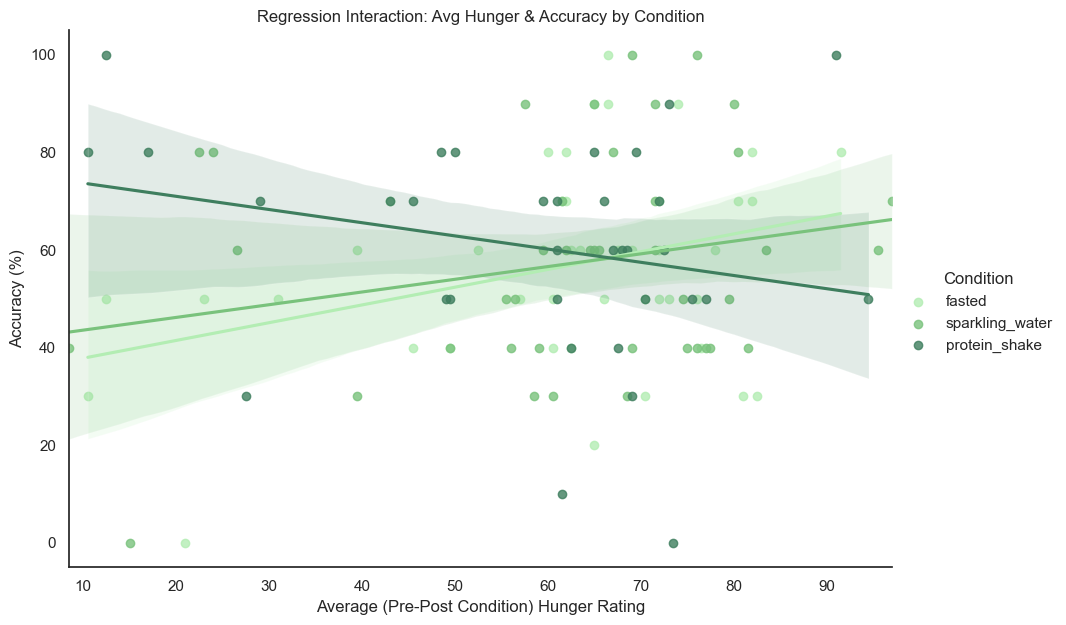

<Figure size 1000x600 with 0 Axes>

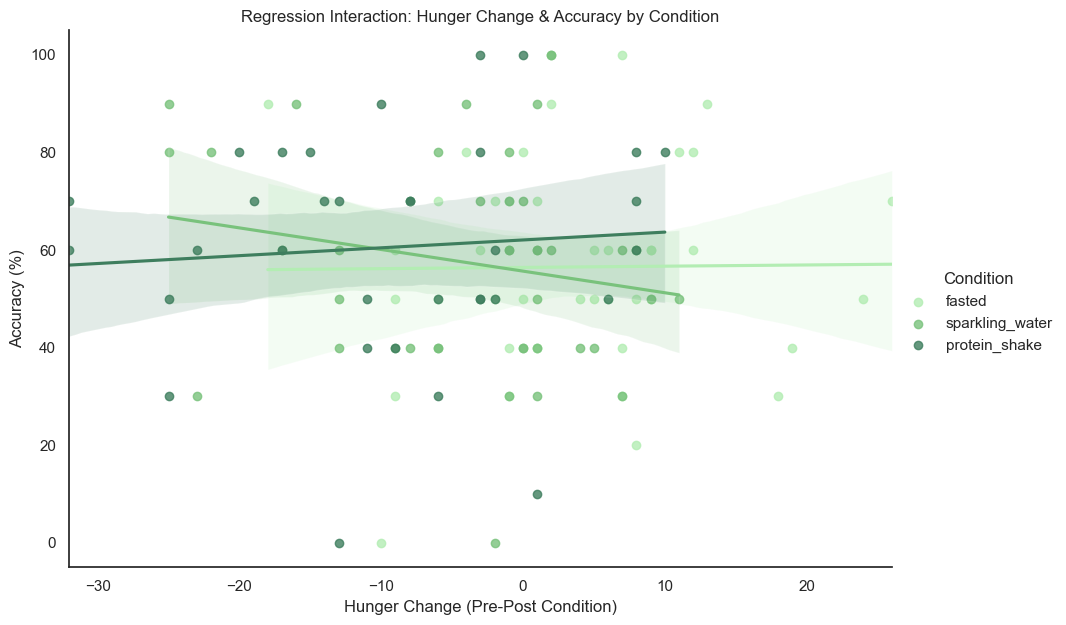

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Define Outlier Removal Function ---
def remove_outliers(df, column):
    """Removes outliers beyond 1.5*IQR range."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# --- Apply Outlier Removal ---
#clean_df = remove_outliers(accuracy_df, "Accuracy_percent")
#clean_df = remove_outliers(clean_df, "avg_hunger")
#clean_df = remove_outliers(clean_df, "hunger_change")
clean_df = accuracy_df
# --- Custom Color Palette ---
condition_palette = {
    'fasted':  (0.702, 0.929, 0.702),   # Dark green
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake': (0.243, 0.494, 0.369)  # Soft, light green
}

# --- Plot: Avg Hunger vs Accuracy ---
plt.figure(figsize=(10, 6))
sns.lmplot(data=clean_df, x="avg_hunger", y="Accuracy_percent", hue="Condition", 
           scatter=True, ci=95, palette=condition_palette, height=6, aspect=1.5)

plt.xlabel("Average (Pre-Post Condition) Hunger Rating")
plt.ylabel("Accuracy (%)")
plt.title("Regression Interaction: Avg Hunger & Accuracy by Condition")
plt.show()

# --- Plot: Hunger Change vs Accuracy ---
plt.figure(figsize=(10, 6))
sns.lmplot(data=clean_df, x="hunger_change", y="Accuracy_percent", hue="Condition", 
           scatter=True, ci=95, palette=condition_palette, height=6, aspect=1.5)

plt.xlabel("Hunger Change (Pre-Post Condition)")
plt.ylabel("Accuracy (%)")
plt.title("Regression Interaction: Hunger Change & Accuracy by Condition")
plt.show()

accuracy_df.to_csv('Accuracy_df.csv')


Is Confidence related to Hunger?

In [ ]:
import pandas as pd
import numpy as np
from pymer4.models import Lmer

# --- Define Outlier Removal Function ---
def remove_outliers(df, column):
    """Removes outliers beyond 1.5*IQR range."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



# Ensure proper data types
accuracy_df['Condition'] = pd.Categorical(accuracy_df['Condition'], categories=['fasted', 'sparkling_water', 'protein_shake'], ordered=True)
accuracy_df['Participant'] = pd.Categorical(accuracy_df['Participant'])

# Merge hunger ratings into accuracy data
merged_df = pd.merge(accuracy_df, df[df['Question_Type'] == 'Hunger'], on='Participant', suffixes=('_acc', '_hung'))

# Initialize lists
avg_hunger_list = []
hunger_change_list = []

# --- Apply Outlier Removal ---
#clean_df = remove_outliers(accuracy_df, "Accuracy_percent")


# Loop through rows of accuracy_df to calculate hunger metrics
for idx, row in accuracy_df.iterrows():
    pid = row['Participant']
    condition = row['Condition']
    
    hunger_vals = df[(df['Participant'] == pid) & (df['Question_Type'] == 'Hunger')]
    
    if condition == 'fasted':
        h1 = hunger_vals[hunger_vals['Instance'] == 1]['Button'].values
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        avg = np.nanmean([h1[0] if len(h1) else np.nan, h2[0] if len(h2) else np.nan])
        delta = (h2[0] - h1[0]) if len(h1) and len(h2) else np.nan

    elif condition == 'sparkling_water':
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        avg = np.nanmean([h2[0] if len(h2) else np.nan, h3[0] if len(h3) else np.nan])
        delta = (h3[0] - h2[0]) if len(h2) and len(h3) else np.nan

    elif condition == 'protein_shake':
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        h4 = hunger_vals[hunger_vals['Instance'] == 4]['Button'].values
        avg = np.nanmean([h3[0] if len(h3) else np.nan, h4[0] if len(h4) else np.nan])
        delta = (h4[0] - h3[0]) if len(h3) and len(h4) else np.nan

    else:
        avg = np.nan
        delta = np.nan

    avg_hunger_list.append(avg)
    hunger_change_list.append(delta)

# Add to dataframe
accuracy_df['avg_hunger'] = avg_hunger_list
accuracy_df['hunger_change'] = hunger_change_list

accuracy_df = remove_outliers(accuracy_df, "avg_hunger")
accuracy_df = remove_outliers(accuracy_df, "hunger_change")

# --- Model 1: Avg Hunger as predictor ---
model1 = Lmer("Confidence ~ Condition + avg_hunger + Condition:avg_hunger + (1|Participant)", data=accuracy_df)
model1.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})
print("\n--- Model 1: Average Hunger ---")
print(model1.summary())

summary = model1.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_avg', row.name, row['P-val']))  # 'name' is the index, which is the predictor


# --- Model 2: Hunger Change as predictor ---
model2 = Lmer("Confidence ~ Condition + hunger_change + Condition:hunger_change + (1|Participant)", data=accuracy_df)
model2.fit(factors = {"Condition": ['fasted','sparkling_water', 'protein_shake']})
print("\n--- Model 2: Hunger Change ---")
print(model2.summary())

summary = model2.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_change', row.name, row['P-val']))  # 'name' is the index, which is the predictor




c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 103	 Groups: {'Participant': 39.0}

Log-likelihood: -403.677 	 AIC: 823.353

Random effects:

                    Name      Var     Std
Participant  (Intercept)  384.824  19.617
Residual                   53.276   7.299

No random effect correlations specified

Fixed effects:


--- Model 1: Average Hunger ---
Linear mixed model fit by REML [’lmerMod’]
Formula: Confidence~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 103	 Groups: {'Participant': 39.0}

Log-likelihood: -403.677 	 AIC: 823.353

Random effects:

                    Name      Var     Std
Participant  (Intercept)  384.824  19.617
Residual                   53.276   7.299

No random effect correlations specified

Fixed effects:

                       Estimate  2.5_

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


### Is AUC related to Hunger?

In [ ]:
import pandas as pd
import numpy as np
from pymer4.models import Lmer

# --- Define Outlier Removal Function ---
def remove_outliers(df, column):
    """Removes outliers beyond 1.5*IQR range."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]



# Ensure proper data types
df_auc['Condition'] = pd.Categorical(df_auc['Condition'], categories=['fasted', 'sparkling_water', 'protein_shake'], ordered=True)
df_auc['Participant'] = pd.Categorical(df_auc['Participant'])

# Merge hunger ratings into accuracy data
merged_df = pd.merge(df_auc, df[df['Question_Type'] == 'Hunger'], on='Participant', suffixes=('_acc', '_hung'))
print(merged_df)
# Initialize lists
avg_hunger_list = []
hunger_change_list = []

# --- Apply Outlier Removal ---
#clean_df = remove_outliers(accuracy_df, "Accuracy_percent")


# Loop through rows of accuracy_df to calculate hunger metrics
for idx, row in df_auc.iterrows():
    pid = row['Participant']
    condition = row['Condition']
    
    hunger_vals = df[(df['Participant'] == pid) & (df['Question_Type'] == 'Hunger')]
    
    if condition == 'fasted':
        h1 = hunger_vals[hunger_vals['Instance'] == 1]['Button'].values
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        avg = np.nanmean([h1[0] if len(h1) else np.nan, h2[0] if len(h2) else np.nan])
        delta = (h2[0] - h1[0]) if len(h1) and len(h2) else np.nan

    elif condition == 'sparkling_water':
        h2 = hunger_vals[hunger_vals['Instance'] == 2]['Button'].values
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        avg = np.nanmean([h2[0] if len(h2) else np.nan, h3[0] if len(h3) else np.nan])
        delta = (h3[0] - h2[0]) if len(h2) and len(h3) else np.nan

    elif condition == 'protein_shake':
        h3 = hunger_vals[hunger_vals['Instance'] == 3]['Button'].values
        h4 = hunger_vals[hunger_vals['Instance'] == 4]['Button'].values
        avg = np.nanmean([h3[0] if len(h3) else np.nan, h4[0] if len(h4) else np.nan])
        delta = (h4[0] - h3[0]) if len(h3) and len(h4) else np.nan

    else:
        avg = np.nan
        delta = np.nan

    avg_hunger_list.append(avg)
    hunger_change_list.append(delta)

# Add to dataframe
df_auc['avg_hunger'] = avg_hunger_list
df_auc['hunger_change'] = hunger_change_list

df_auc = remove_outliers(df_auc, "avg_hunger")
df_auc = remove_outliers(df_auc, "hunger_change")

# --- Model 1: Avg Hunger as predictor ---
model1 = Lmer("AUC ~ Condition + avg_hunger + Condition:avg_hunger + (1|Participant)", data=df_auc)
model1.fit()
print("\n--- Model 1: Average Hunger ---")
print(model1.summary())

summary = md.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_avg', row.name, row['P-val']))  # 'name' is the index, which is the predictor


# --- Model 2: Hunger Change as predictor ---
model2 = Lmer("AUC ~ Condition + hunger_change + Condition:hunger_change + (1|Participant)", data=df_auc)
model2.fit()
print("\n--- Model 2: Hunger Change ---")
print(model2.summary())

summary = md.summary()
for _, row in summary.iterrows():
    #print(row)
    # Use the index for the predictor (this is the row label, not a column)
    results.append((f'Acc_Hunger_change', row.name, row['P-val']))  # 'name' is the index, which is the predictor




    Participant  Condition_acc       AUC     Trial Participant_Sound_Loc  \
0           004         fasted  0.888889  Question               Hunger1   
1           004         fasted  0.888889  Question               Hunger2   
2           004         fasted  0.888889  Question               Hunger3   
3           004         fasted  0.888889  Question               Hunger4   
4           006         fasted  0.880000  Question               Hunger1   
..          ...            ...       ...       ...                   ...   
535         141  protein_shake  0.500000  Question               Hunger4   
536         142  protein_shake  0.458333  Question               Hunger1   
537         142  protein_shake  0.458333  Question               Hunger2   
538         142  protein_shake  0.458333  Question               Hunger3   
539         142  protein_shake  0.458333  Question               Hunger4   

     Button Question_Type  Instance Condition_hung  
0        74        Hunger         

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: AUC~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'Participant': 42.0}

Log-likelihood: -14.424 	 AIC: 44.848

Random effects:

                    Name    Var    Std
Participant  (Intercept)  0.006  0.079
Residual                  0.046  0.215

No random effect correlations specified

Fixed effects:


--- Model 1: Average Hunger ---
Linear mixed model fit by REML [’lmerMod’]
Formula: AUC~Condition+avg_hunger+Condition:avg_hunger+(1|Participant)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'Participant': 42.0}

Log-likelihood: -14

c:\Users\hsavage\Documents\GitHub\Em-Body_toolkit-1\myenv\lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


<Figure size 1000x600 with 0 Axes>

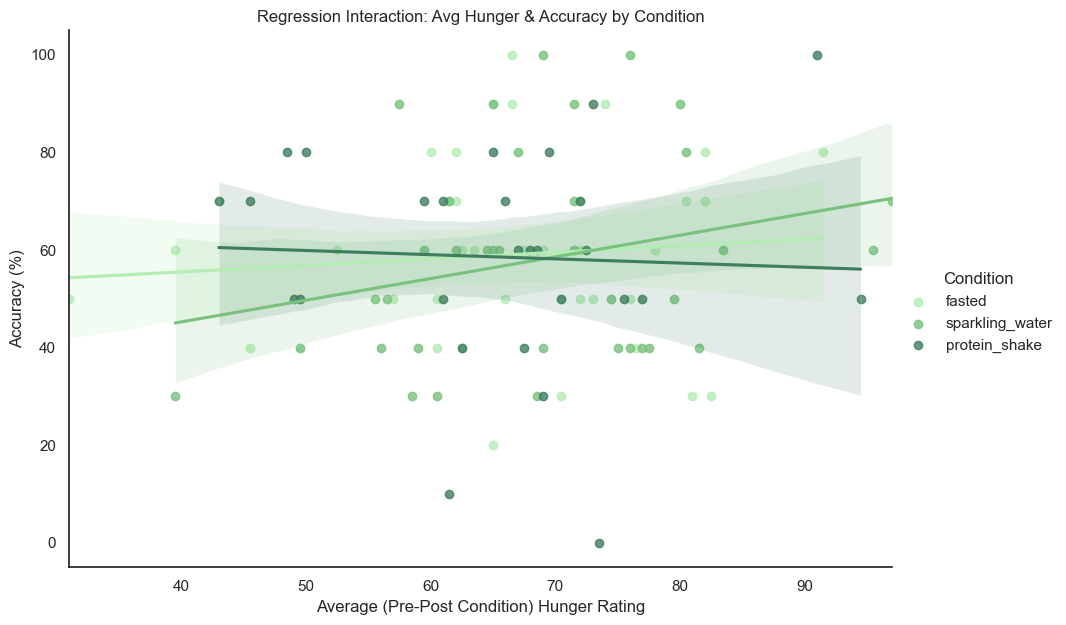

<Figure size 1000x600 with 0 Axes>

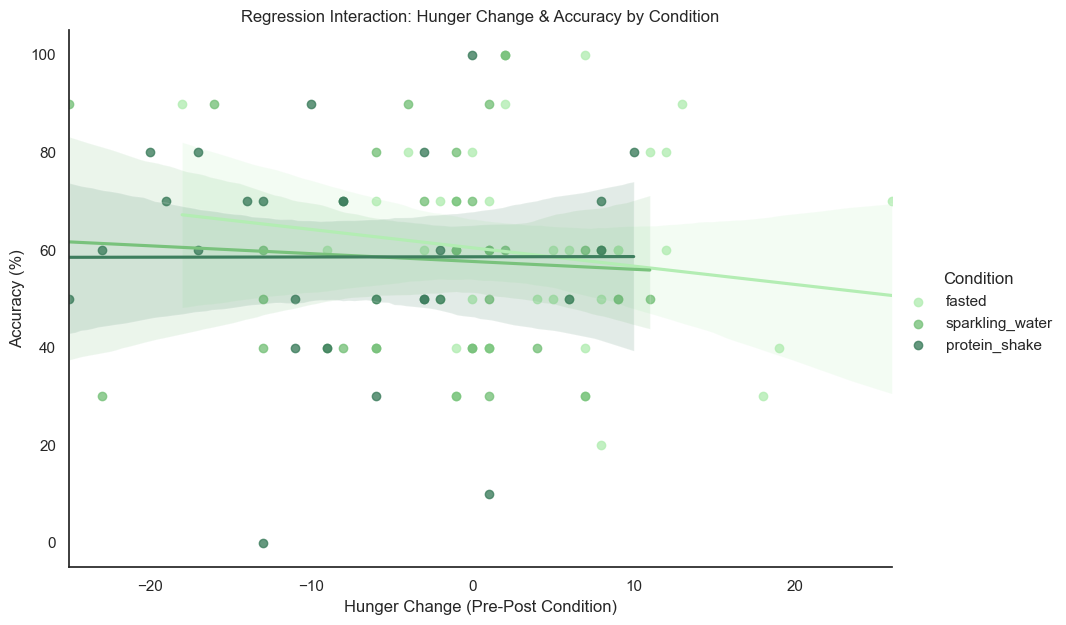

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Define Outlier Removal Function ---
def remove_outliers(df, column):
    """Removes outliers beyond 1.5*IQR range."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# --- Apply Outlier Removal ---
#clean_df = remove_outliers(accuracy_df, "Accuracy_percent")
#clean_df = remove_outliers(clean_df, "avg_hunger")
#clean_df = remove_outliers(clean_df, "hunger_change")
clean_df = accuracy_df
# --- Custom Color Palette ---
condition_palette = {
    'fasted':  (0.702, 0.929, 0.702),   # Dark green
    'sparkling_water': (0.474, 0.759, 0.486),  # Lighter green
    'protein_shake': (0.243, 0.494, 0.369)  # Soft, light green
}

# --- Plot: Avg Hunger vs Accuracy ---
plt.figure(figsize=(10, 6))
sns.lmplot(data=clean_df, x="avg_hunger", y="Accuracy_percent", hue="Condition", 
           scatter=True, ci=95, palette=condition_palette, height=6, aspect=1.5)

plt.xlabel("Average (Pre-Post Condition) Hunger Rating")
plt.ylabel("Accuracy (%)")
plt.title("Regression Interaction: Avg Hunger & Accuracy by Condition")
plt.show()

# --- Plot: Hunger Change vs Accuracy ---
plt.figure(figsize=(10, 6))
sns.lmplot(data=clean_df, x="hunger_change", y="Accuracy_percent", hue="Condition", 
           scatter=True, ci=95, palette=condition_palette, height=6, aspect=1.5)

plt.xlabel("Hunger Change (Pre-Post Condition)")
plt.ylabel("Accuracy (%)")
plt.title("Regression Interaction: Hunger Change & Accuracy by Condition")
plt.show()

accuracy_df.to_csv('Accuracy_df.csv')


### Drink preferences

In [ ]:
# Filter data for 'Drink' question type
drink_data = df[df['Question_Type'] == 'Drink']

# Ensure instances are numeric
drink_data['Instance'] = pd.to_numeric(drink_data['Instance'])

# Pivot data to get paired values (Instance 1 and Instance 2)
paired_data = drink_data.pivot(index='Participant', columns='Instance', values='Button')

# Drop any rows with missing values
paired_data = paired_data.dropna(subset=[1, 2])
#print(paired_data[1])
#print(paired_data[2])

# Perform paired t-test between Instance 2 and Instance 1
t_stat, p_value = ttest_rel(paired_data[2], paired_data[1])

print(f'Paired t-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.10f}')

results.append((f'Drinks', 't-test', p_value))  # 'name' is the index, which is the predictor



Paired t-test results: t-statistic = -7.0283, p-value = 0.0000000104


C:\Users\hsavage\AppData\Local\Temp\ipykernel_26876\4240128354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drink_data['Instance'] = pd.to_numeric(drink_data['Instance'])


Correct for multiple comparisions 
Make sure to save, load and append the sound tests, and then apply the correction

In [ ]:
# Collect p-values
p_vals = [r[2] for r in results]
# You can also store the corresponding test info (but keep the same order for now)
test_info = [r[:2] for r in results]  # [('Test1', 'Condition1'), ...]

# Apply p-value correction using p_methods (adjusting alpha as needed)
corrected = p_methods(p_vals, pv_index=0, alpha=0.05)

# Now, create a DataFrame for the corrected results
corrected_df = pd.DataFrame({
    'p_value': p_vals,
    'bh_value': corrected['bh_value'],
    'bh_significant': corrected['bh_significant'],
    'bonf_value': corrected['bonf_value'],
    'bonf_significant': corrected['bonf_significant']
})

test_info_df = pd.DataFrame(test_info, columns=['Test', 'Component'])

# Re-order the test_info DataFrame to match the index of corrected_df
# Sort test_info_df by the index to match the p-values order after correction
test_info_df = test_info_df.iloc[corrected_df.index]

# Now join the test info with the corrected p-values DataFrame
corrected_df = corrected_df.join(test_info_df)

# Display the final DataFrame
print(corrected_df)

         p_value  bh_value  bh_significant  bonf_value  bonf_significant  \
0   0.000000e+00  0.000943            True    0.000943              True   
50  4.450000e-01  0.000943            True    0.000943              True   
48  3.260000e-01  0.000943            True    0.000943              True   
3   0.000000e+00  0.000943            True    0.000943              True   
42  6.200000e-02  0.000943            True    0.000943              True   
30  2.320000e-01  0.000943            True    0.000943              True   
6   0.000000e+00  0.000943            True    0.000943              True   
21  1.000000e-03  0.000943            True    0.000943              True   
18  9.890000e-01  0.000943            True    0.000943              True   
15  3.820000e-01  0.000943            True    0.000943              True   
12  5.980000e-01  0.000943            True    0.000943              True   
52  5.130000e-01  0.011321            True    0.000943              True   
7   0.000000

In [ ]:
alpha = 0.05
m = len(p_vals)
bonf_threshold = alpha / m
bh_thresholds = [(i + 1) / m * alpha for i in range(m)]

print(f"Bonferroni threshold: {bonf_threshold:.5f}")
print("Top 5 BH thresholds:")
for i, bh in enumerate(bh_thresholds[:15]):
    print(f"Rank {i+1}: {bh:.5f}")

Bonferroni threshold: 0.00094
Top 5 BH thresholds:
Rank 1: 0.00094
Rank 2: 0.00189
Rank 3: 0.00283
Rank 4: 0.00377
Rank 5: 0.00472
Rank 6: 0.00566
Rank 7: 0.00660
Rank 8: 0.00755
Rank 9: 0.00849
Rank 10: 0.00943
Rank 11: 0.01038
Rank 12: 0.01132
Rank 13: 0.01226
Rank 14: 0.01321
Rank 15: 0.01415
